In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np
import pandas as pd

import mplhep as hep
plt.style.use(hep.style.CMS)

In [2]:
output_folder = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/RecoPlots/RecoComparison_v1"
os.makedirs(output_folder, exist_ok=True)

In [3]:
dfall_ele = pd.HDFStore(output_folder + "/dataset_electron.h5py", "r")["df"]
dfall_gamma = pd.HDFStore(output_folder + "/dataset_photon.h5py", "r")["df"]

In [4]:
df_ele_old = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03/validation_data/validation_dataset_v11_ele.csv", sep=";")
df_gamma_old = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v19/run_03/validation_data/validation_dataset_v11_gamma.csv", sep=";")
# df_nomatch = pd.read_csv("/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v11/run_01/en_regr/run_01/validation_data/validation_dataset_v10_nomatch.csv", sep=";")

In [10]:
for dfall in [dfall_ele, dfall_gamma]:
    dfall["eta"] = dfall["calo_geneta"].abs()
    dfall["phi"] = dfall["calo_genphi"]
    dfall["En_ovEtrue_deepsc"] = dfall["en_deepsc_raw"] / dfall["calo_en_true_sim"]
    dfall["En_ovEtrue_mustache"] = dfall["en_mustache_raw"] / dfall["calo_en_true_sim"]
    
df_ele = dfall_ele.loc[(dfall_ele.in_deepsc == 1) & (dfall_ele.in_mustache==1)]
df_gamma = dfall_gamma.loc[(dfall_gamma.in_deepsc == 1) & (dfall_gamma.in_mustache==1)]

In [7]:
def bin_analysis(col):
    def f(df):
        m = df[col].mean()
        A = (df[col].quantile(0.84) - df[col].quantile(0.16))/2
        B = (df[col].quantile(0.975) - df[col].quantile(0.025))/2
        return pd.Series({
            "m": m,
            "w68": A,
            "w95": B,
            "N": df[col].count()
        })
    return f

def bin_analysis_central(col):
    def f(df):
        m = df[col].mean()
        qM = np.sum(df[col]< m) / df[col].count()
        print(qM)
        if (qM> 0.66):
            A = (df[col].quantile(1) - df[col].quantile(qM-0.34))/2
        elif (qM < 0.34):
            A = (df[col].quantile(qM +0.34) - df[col].quantile(0))/2
        else:
            A = (df[col].quantile(qM +0.34) - df[col].quantile(qM-0.34))/2
        return pd.Series({
            "m": m,
            "qM": qM,
            "w68": A,
            "N": df[col].count()
        })
    return f

# Basic checks

In [8]:
for dfall, flavour in zip([dfall_ele, dfall_gamma],["Electron","Photon"]):

    inM_inD = np.sum((dfall.in_mustache)& (dfall.in_deepsc))
    noM_inD = np.sum((dfall.in_mustache==0)& (dfall.in_deepsc))
    noM_noD = np.sum((dfall.in_mustache==0)& (dfall.in_deepsc==0))
    inM_noD = np.sum((dfall.in_mustache)& (dfall.in_deepsc==0))
    tot = inM_inD + noM_inD + noM_noD + inM_noD
    
    print(flavour)
    print("In both: {:.3f}".format(inM_inD/tot))
    print("Only DeepSC: {:.3f}".format(noM_inD/tot))
    print("Only Mustache: {:.3f}".format(inM_noD/tot))
    print("Not reconstructed: {:.3f}".format(noM_noD/tot))

Electron
In both: 0.940
Only DeepSC: 0.001
Only Mustache: 0.001
Not reconstructed: 0.057
Photon
In both: 0.946
Only DeepSC: 0.001
Only Mustache: 0.001
Not reconstructed: 0.051


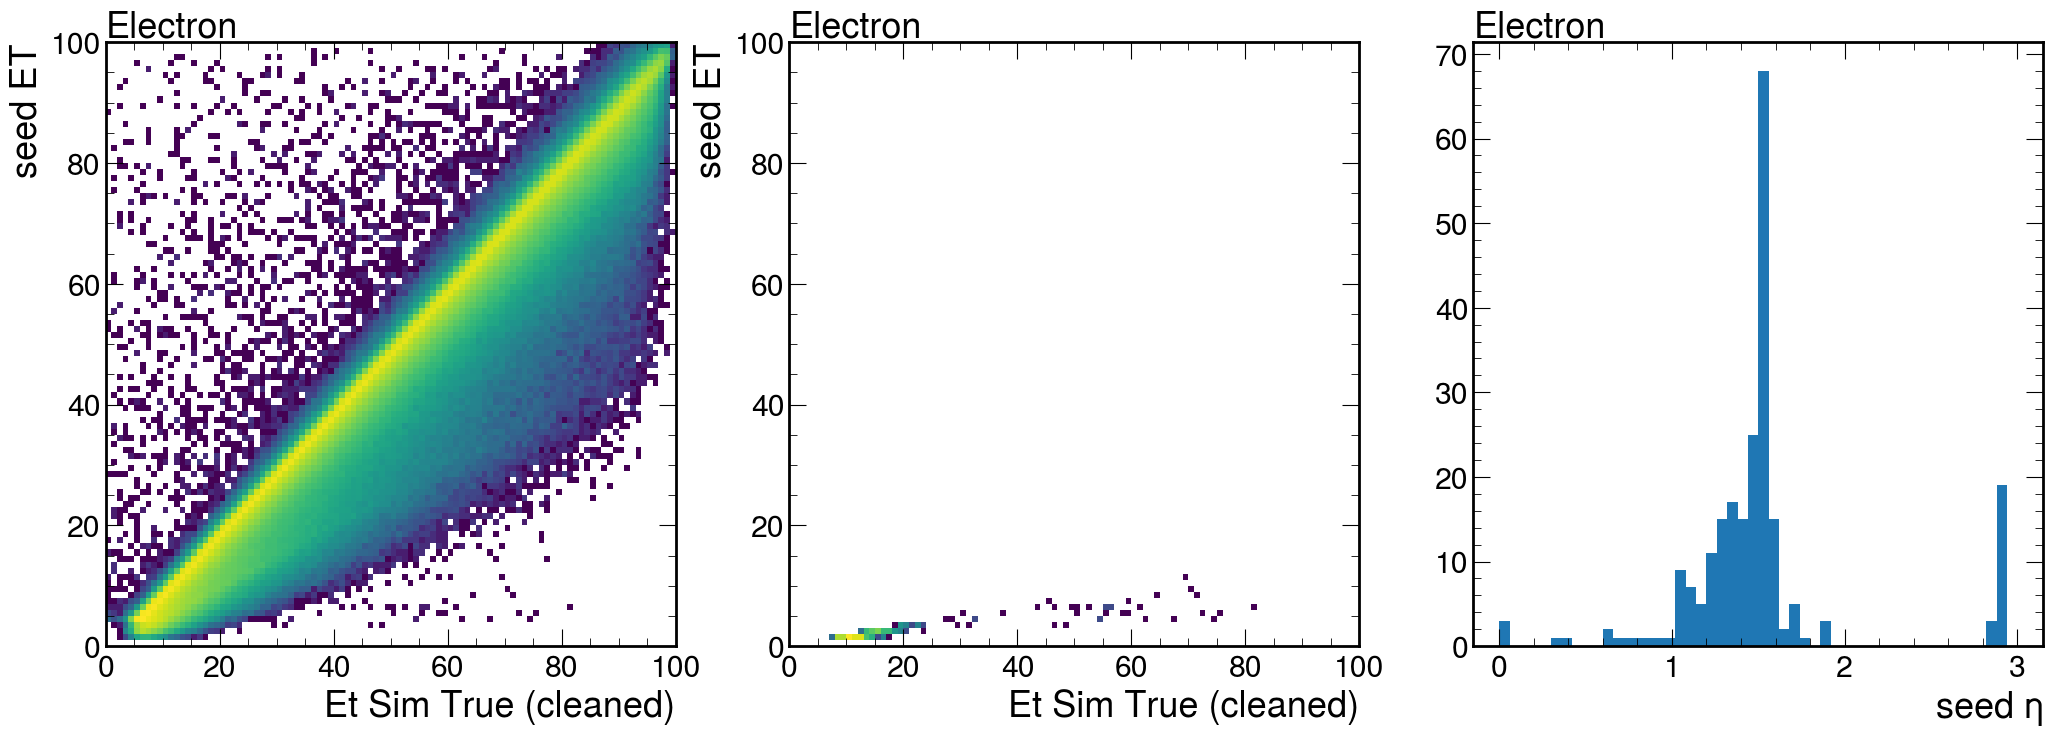

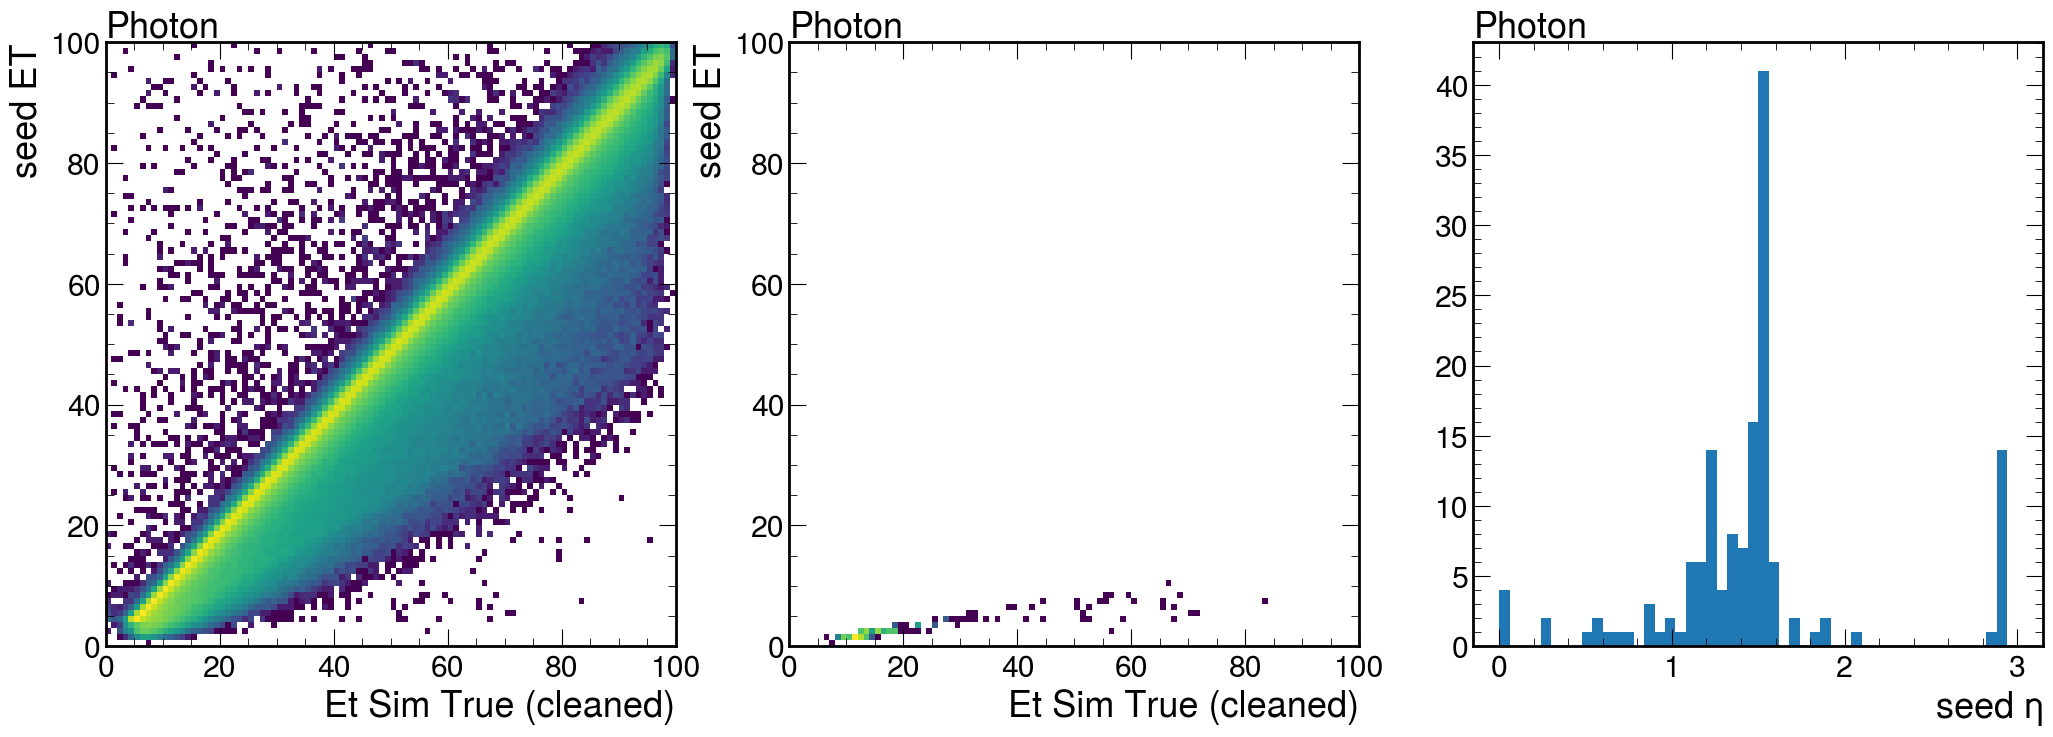

In [18]:
for df, flavour in zip ([df_ele, df_gamma], ["Electron","Photon"]):
    fig, (ax,ay,az) = plt.subplots(1,3, figsize=(25,8), dpi=100)

    ax.hist2d(df.calo_et_true_sim, df.et_seed, bins=(100,100), range=((0,100),(0,100)), cmin=1, norm=colors.LogNorm())
    ax.set_xlabel("Et Sim True (cleaned)")
    ax.set_ylabel("seed ET")
    ax.text(0., 1.01, flavour, transform=ax.transAxes)

    mask = df.calo_et_true_sim > 6 * df.et_seed

    ay.hist2d(df[mask].calo_et_true_sim,df[mask].et_seed, bins=(100,100), range=((0,100),(0,100)), cmin=1,norm=colors.LogNorm())
    ay.set_xlabel("Et Sim True (cleaned)")
    ay.set_ylabel("seed ET")
    ay.text(0., 1.01, flavour, transform=ay.transAxes)
    
    az.hist(df[mask].eta.abs(), bins=50, range=(0,3))
    az.set_xlabel("seed $\eta$")
    az.text(0., 1.01, flavour, transform=az.transAxes)

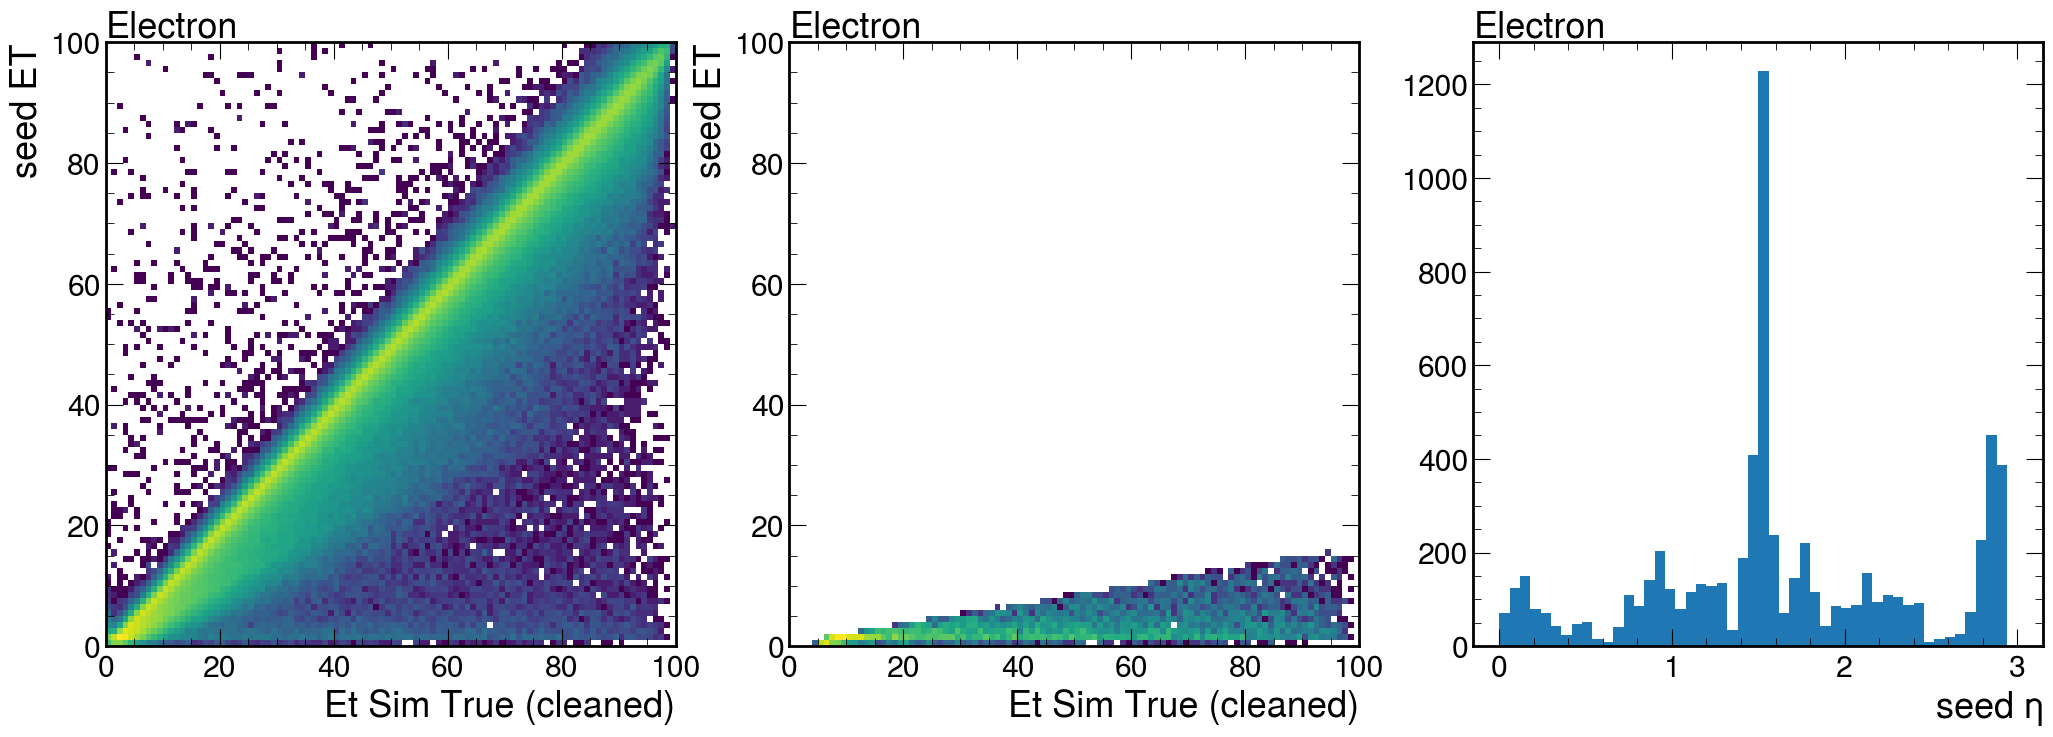

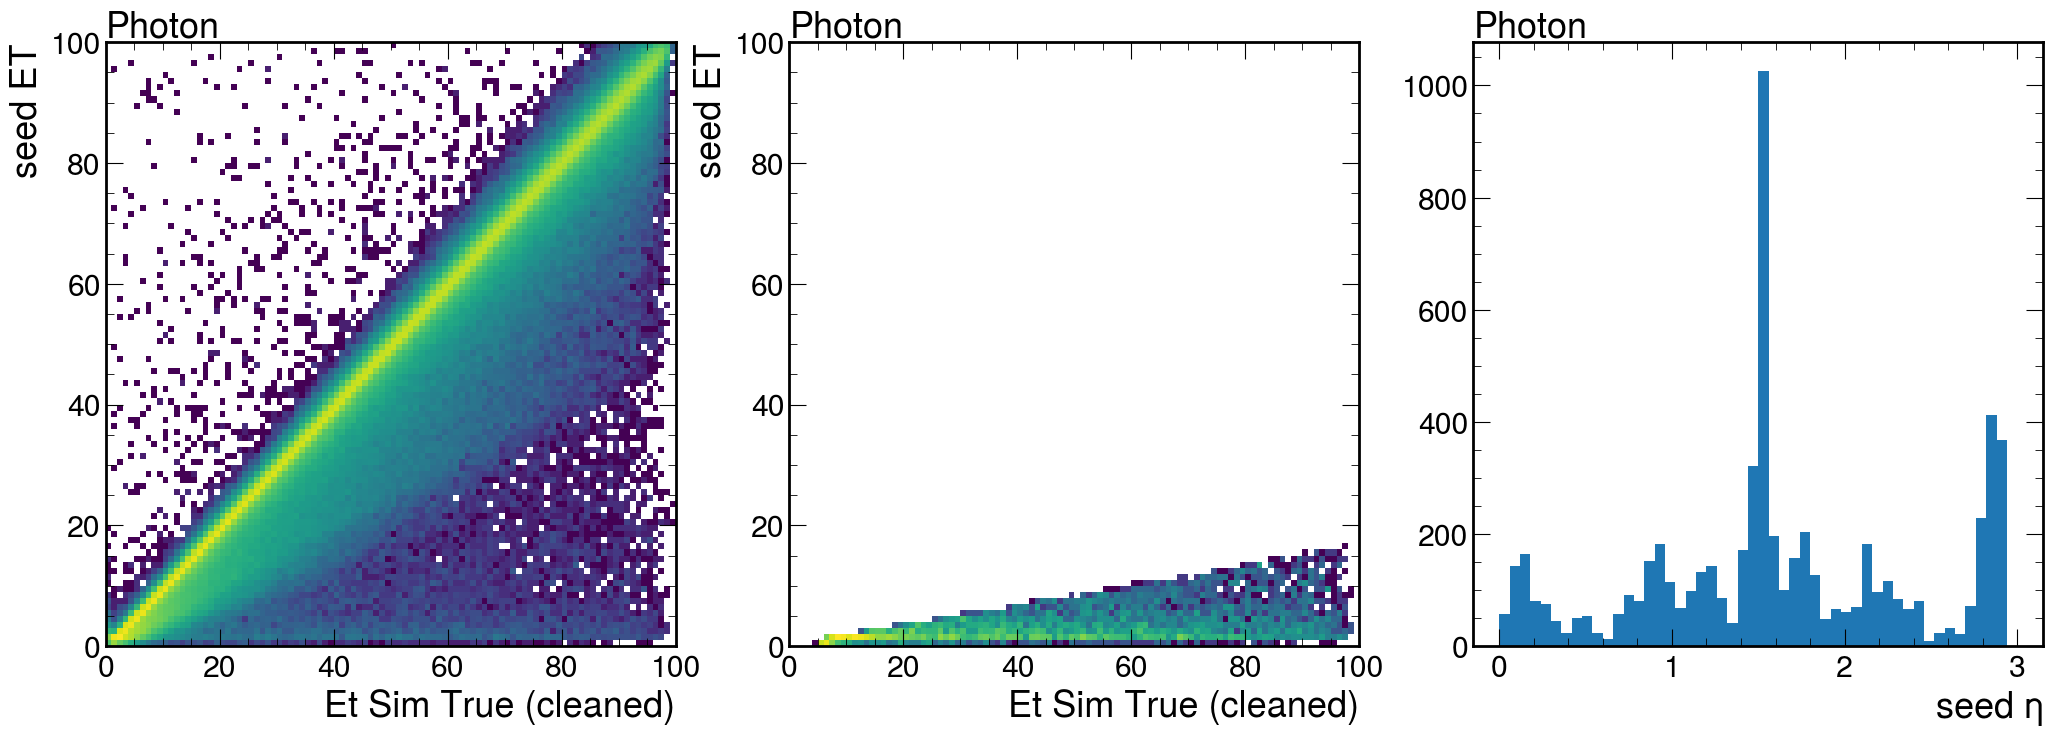

In [16]:
for df, flavour in zip ([df_ele_old, df_gamma_old], ["Electron","Photon"]):
    fig, (ax,ay,az) = plt.subplots(1,3, figsize=(25,8), dpi=100)

    ax.hist2d(df.et_true_sim, df.et_seed, bins=(100,100), range=((0,100),(0,100)), cmin=1, norm=colors.LogNorm())
    ax.set_xlabel("Et Sim True (cleaned)")
    ax.set_ylabel("seed ET")
    ax.text(0., 1.01, flavour, transform=ax.transAxes)

    mask = df.et_true_sim > 6 * df.et_seed

    ay.hist2d(df[mask].et_true_sim,df[mask].et_seed, bins=(100,100), range=((0,100),(0,100)), cmin=1,norm=colors.LogNorm())
    ay.set_xlabel("Et Sim True (cleaned)")
    ay.set_ylabel("seed ET")
    ay.text(0., 1.01, flavour, transform=ay.transAxes)
    
    az.hist(df[mask].seed_eta.abs(), bins=50, range=(0,3))
    az.set_xlabel("seed $\eta$")
    az.text(0., 1.01, flavour, transform=az.transAxes)

Text(1, 0, 'Calo ET true SIM')

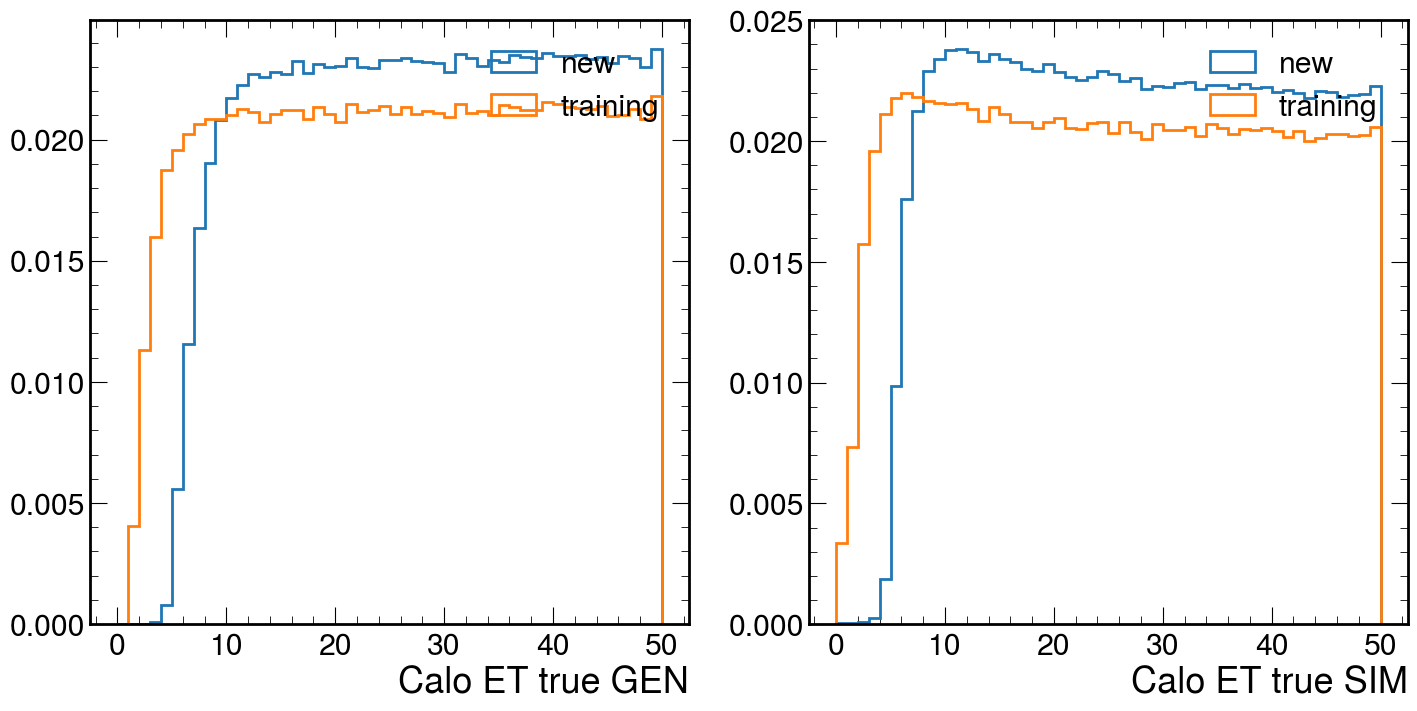

In [31]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=100)
ax.hist(df_ele.calo_et_true_gen, bins=50, range=(0,50), label="new", histtype="step", density=True, linewidth=2)
ax.hist(df_ele_old.et_true_gen, bins=50, range=(0,50), label="training",histtype="step", density=True, linewidth=2)
ax.legend()
ax.set_xlabel("Calo ET true GEN")

ay.hist(df_ele.calo_et_true_sim, bins=50, range=(0,50), label="new", histtype="step", density=True, linewidth=2)
ay.hist(df_ele_old.et_true_sim, bins=50, range=(0,50), label="training",histtype="step", density=True, linewidth=2)
ay.legend()
ay.set_xlabel("Calo ET true SIM")

Text(1, 0, 'Seed $\\eta$')

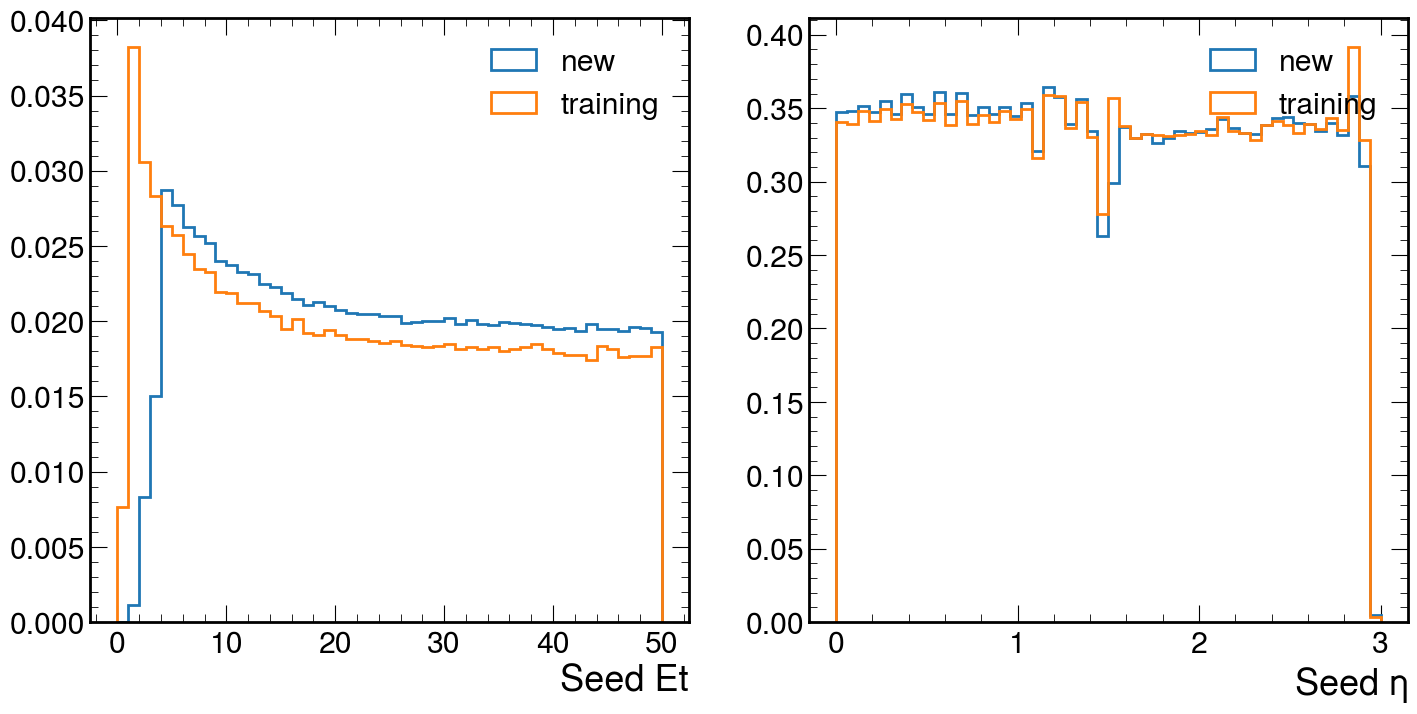

In [53]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=100)
ax.hist(df_ele.et_seed, bins=50, range=(0,50), label="new", histtype="step", density=True, linewidth=2)
ax.hist(df_ele_old.et_seed, bins=50, range=(0,50), label="training",histtype="step", density=True, linewidth=2)
ax.legend()
ax.set_xlabel("Seed Et")

ay.hist(df_ele.seed_eta.abs(), bins=50, range=(0,3), label="new", histtype="step", density=True, linewidth=2)
ay.hist(df_ele_old.seed_eta.abs(), bins=50, range=(0,3), label="training",histtype="step", density=True, linewidth=2)
ay.legend()
ay.set_xlabel("Seed $\eta$")

Text(0, 1, 'Seed eta')

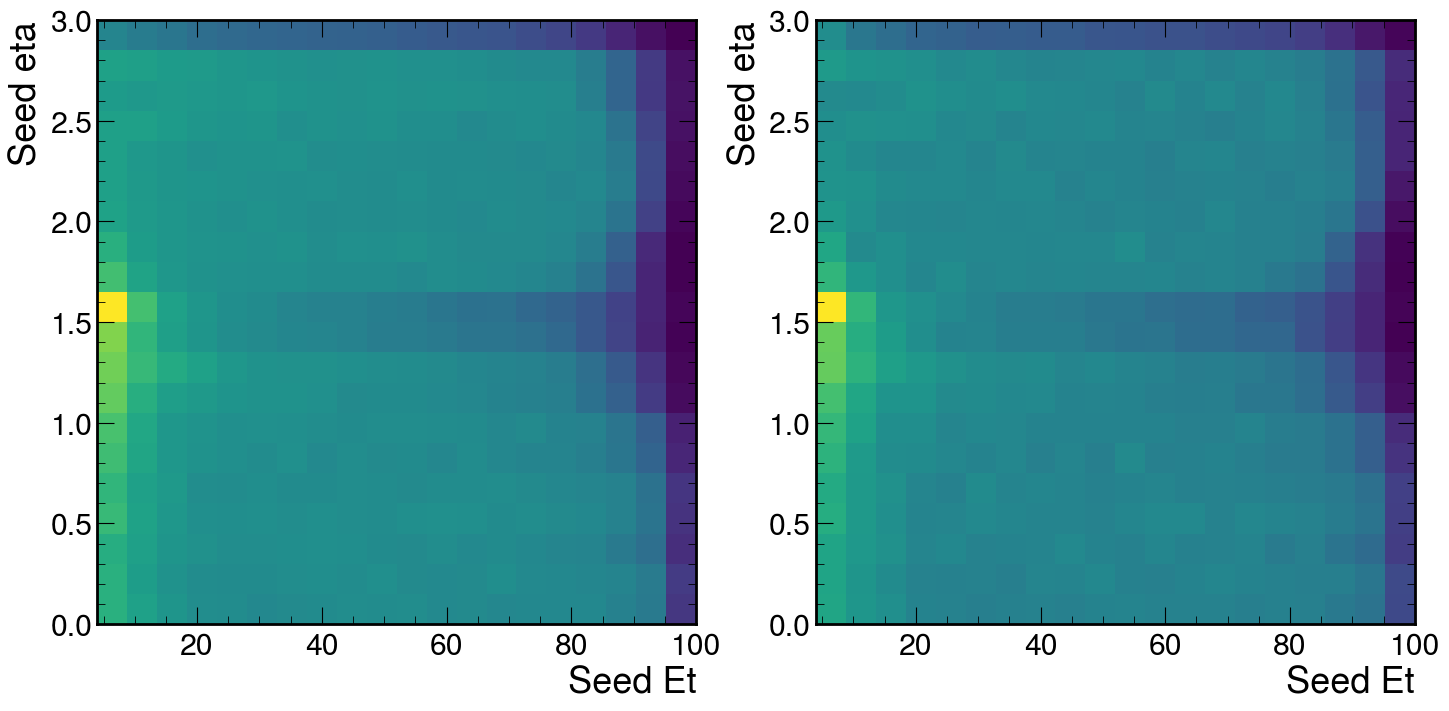

In [124]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=100)
ax.hist2d(df_ele.et_seed, df_ele.seed_eta.abs(), bins=(20,20), range=((4,100),(0,3)), density=True)
ay.hist2d(df_ele_old.et_seed, df_ele_old.seed_eta.abs(), bins=(20,20), range=((4,100),(0,3)), density=True)

ax.set_xlabel("Seed Et")
ax.set_ylabel("Seed eta")
ay.set_xlabel("Seed Et")
ay.set_ylabel("Seed eta")

Text(0, 1, 'Seed eta')

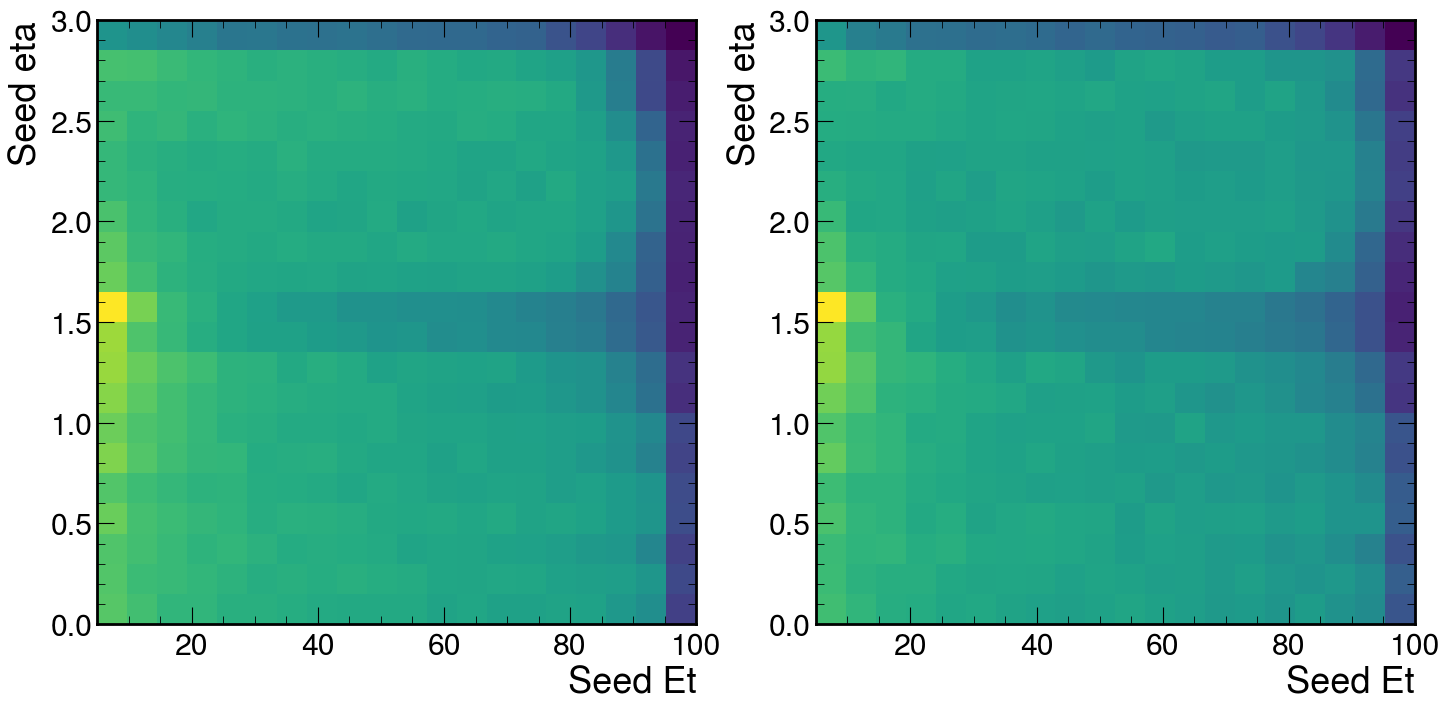

In [58]:
fig, (ax,ay) = plt.subplots(1,2, figsize=(17,8), dpi=100)
ax.hist2d(df_gamma.et_seed, df_gamma.seed_eta.abs(), bins=(20,20), range=((5,100),(0,3)), density=True)
ay.hist2d(df_gamma_old.et_seed, df_gamma_old.seed_eta.abs(), bins=(20,20), range=((5,100),(0,3)), density=True)

ax.set_xlabel("Seed Et")
ax.set_ylabel("Seed eta")
ay.set_xlabel("Seed Et")
ay.set_ylabel("Seed eta")

Comparison between geneta, simeta e seedeta. In the production a distance cut on seed_eta-geneta is made --> visible

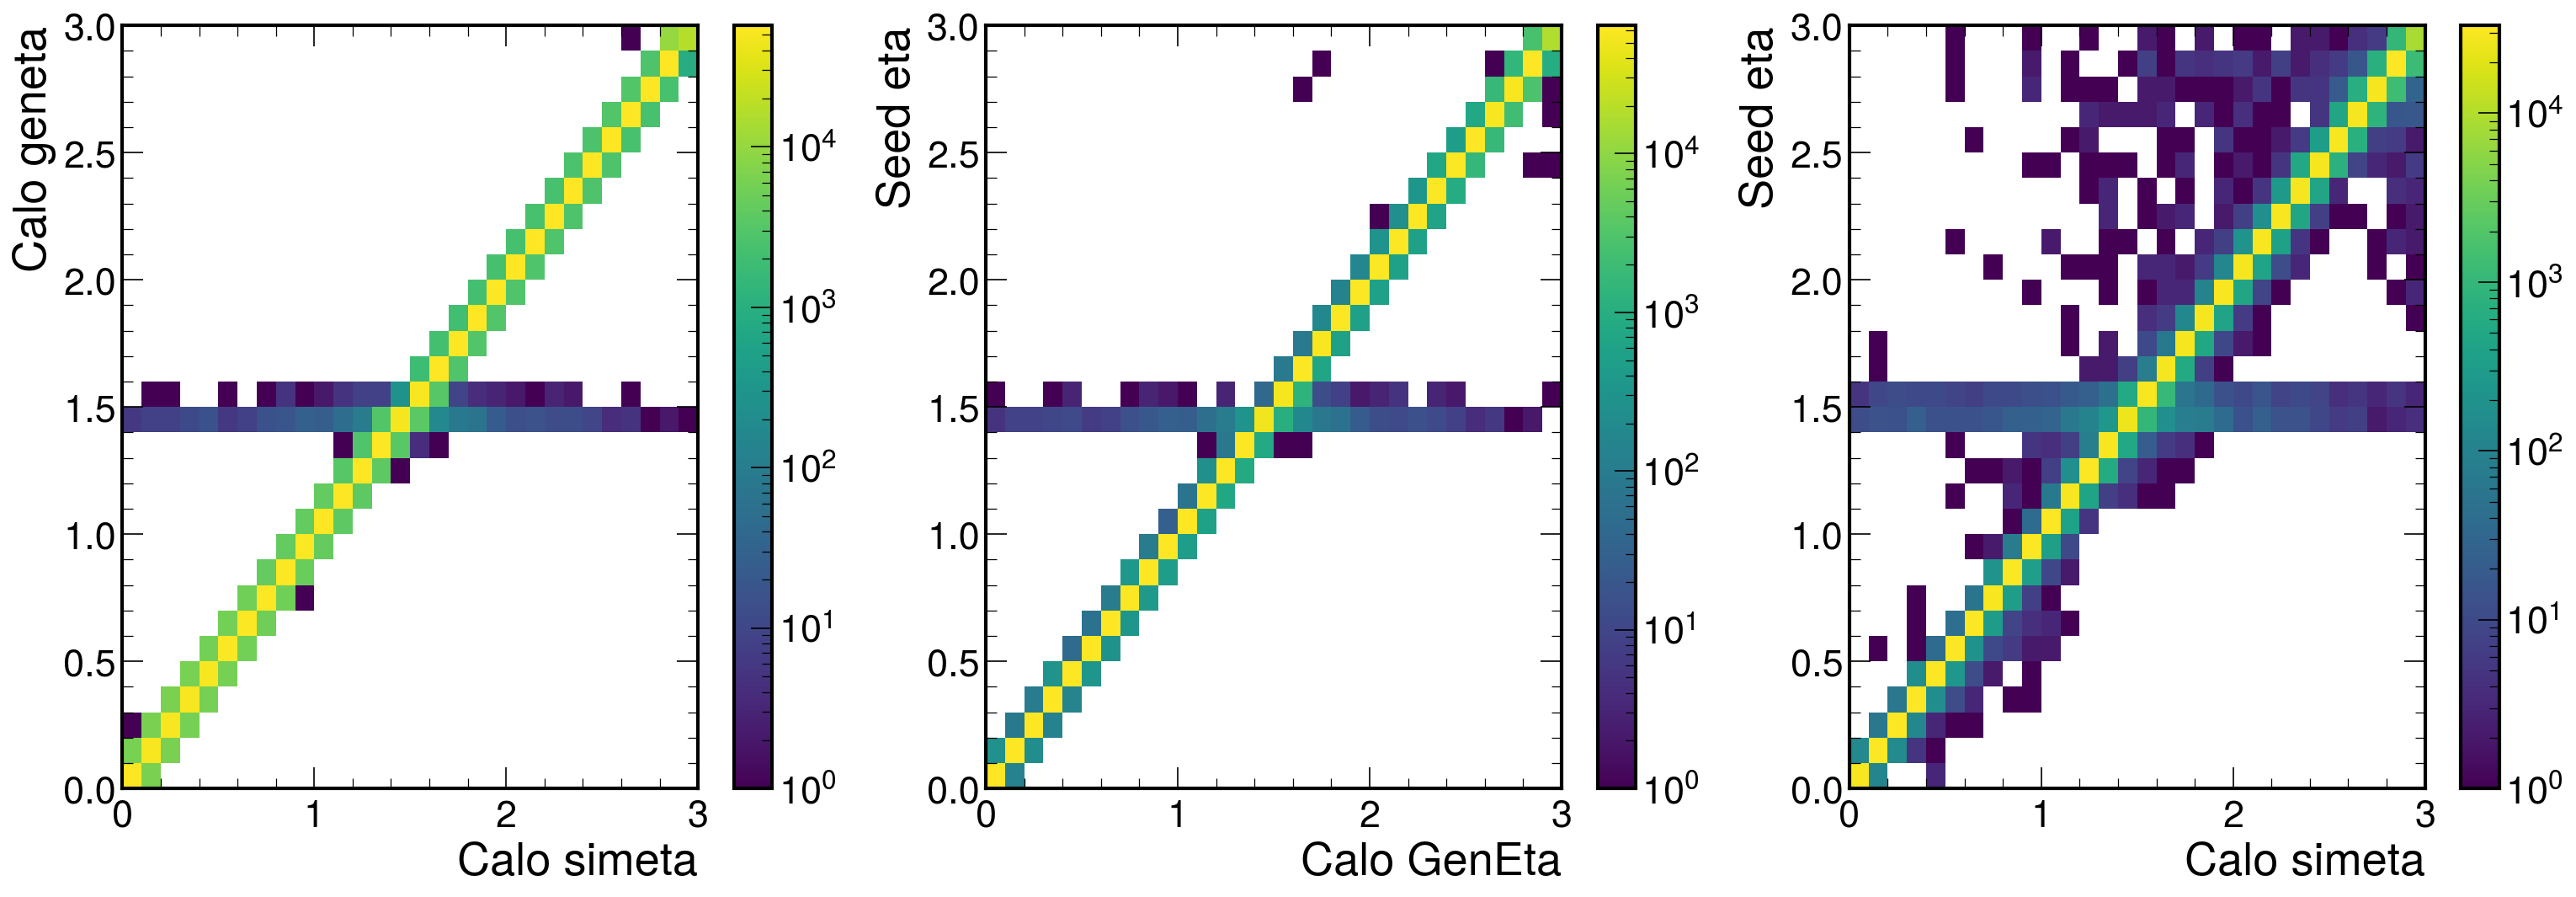

In [49]:
fig, (ax,az,ay) = plt.subplots(1,3, figsize=(25, 8), dpi=150)
mask = df_ele.calo_en_true_gen > 1
A = ax.hist2d(df_ele[mask].calo_simeta.abs(), df_ele[mask].calo_geneta.abs() , bins=(30,30), range=((0,3),(0,3)), norm=colors.LogNorm())
ax.set_xlabel("Calo simeta")
ax.set_ylabel("Calo geneta")
plt.colorbar(A[3], ax=ax)

mask =df_ele.calo_en_true_gen > 1
A = az.hist2d(df_ele[mask].calo_simeta.abs(), df_ele[mask].seed_eta.abs() , bins=(30,30), range=((0,3),(0,3)), norm=colors.LogNorm())
az.set_xlabel("Calo GenEta")
az.set_ylabel("Seed eta")
plt.colorbar(A[3], ax=az)

mask = df_ele_old.en_true_gen > 1
A = ay.hist2d(df_ele_old[mask].sim_true_eta.abs(), df_ele_old[mask].seed_eta.abs() , bins=(30,30), range=((0,3),(0,3)), norm=colors.LogNorm())
ay.set_xlabel("Calo simeta")
ay.set_ylabel("Seed eta")
plt.colorbar(A[3], ax=ay)

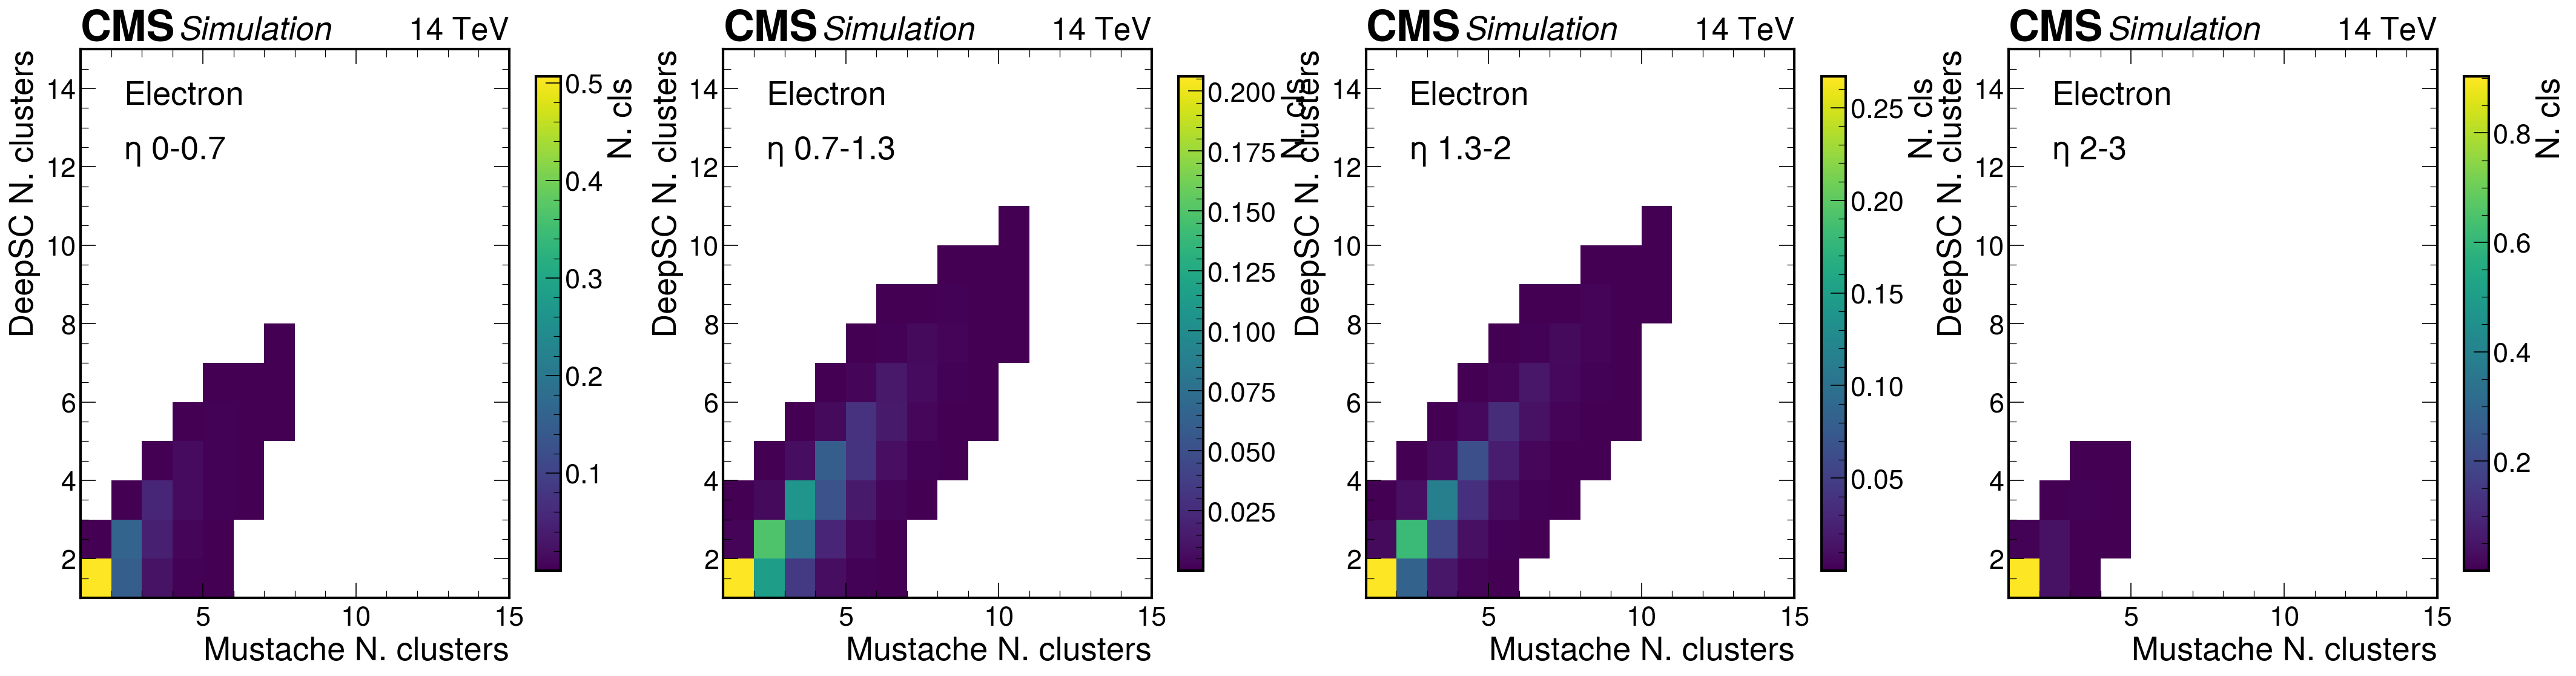

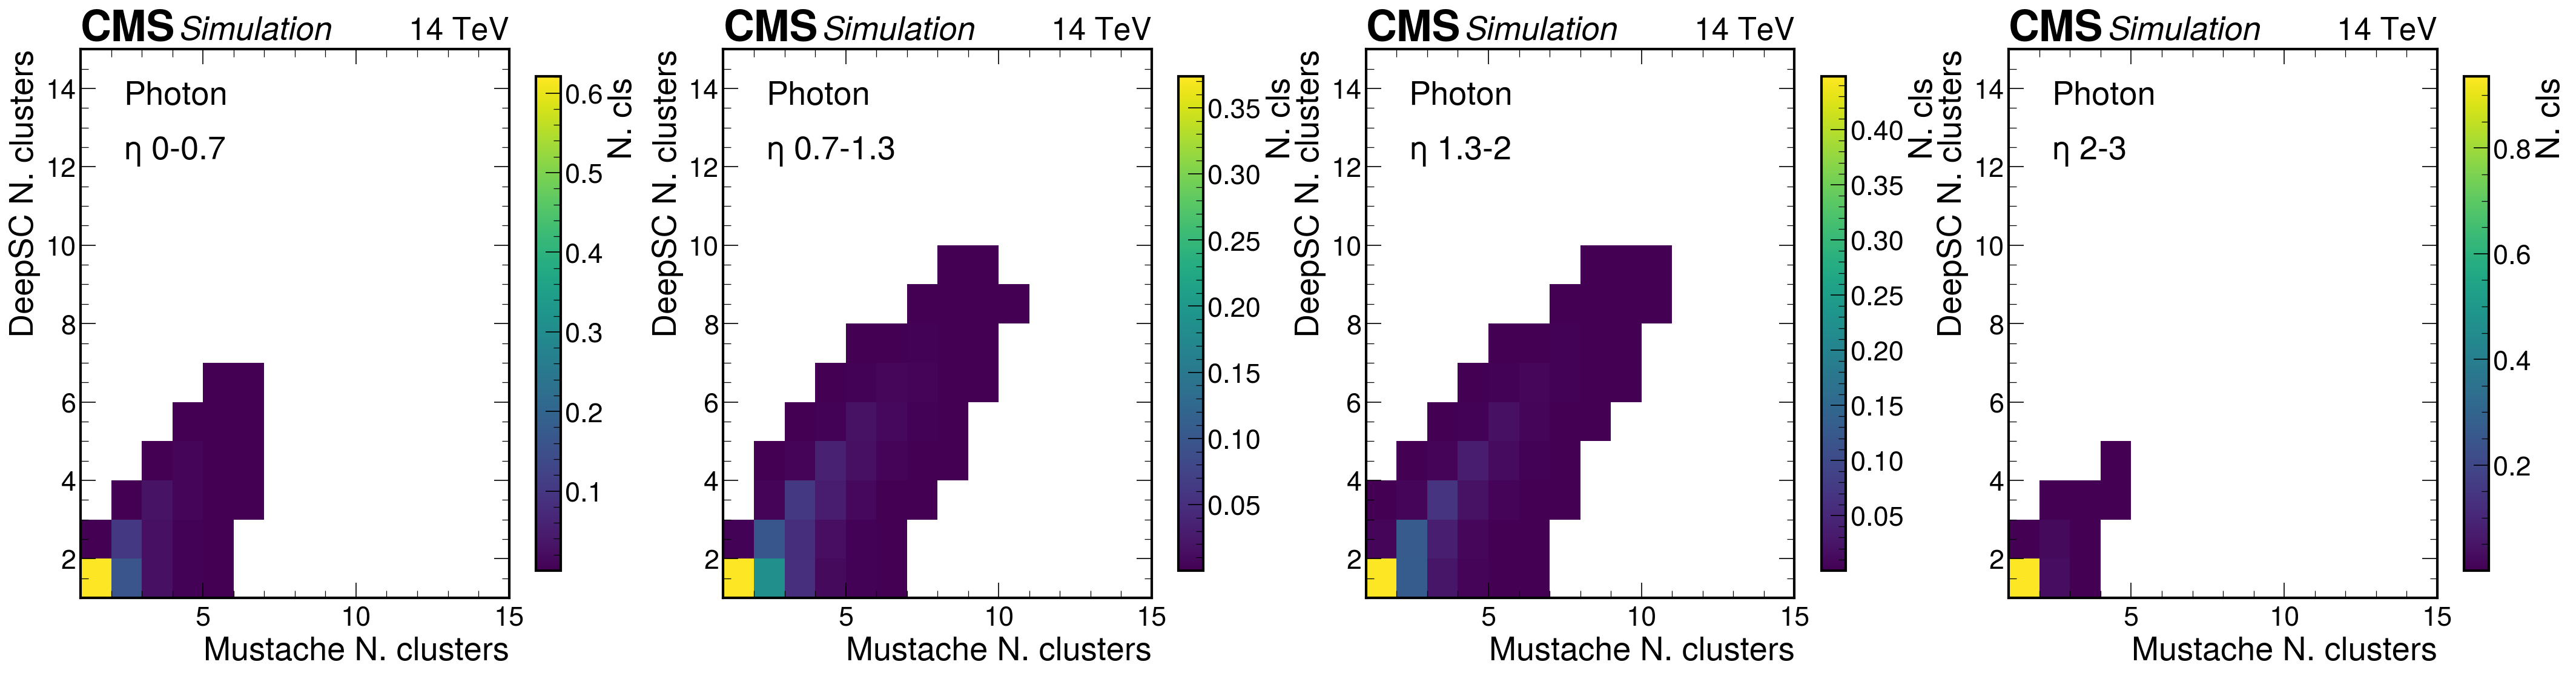

In [60]:
etas =  [0, 0.7, 1.3, 2, 3]


for df, flavour in zip ([df_ele, df_gamma], ["Electron","Photon"]):
    
    fig, ax = plt.subplots(1,len(etas)-1, figsize=(35,8),dpi=150)
    for i in range(len(etas)-1):
        mask = (df.eta>etas[i]) & (df.eta< etas[i+1])
        A = ax[i].hist2d(df[mask].mustache_ncls, df[mask].deepsc_ncls, range=((1, 15), (1,15)), bins=(14,14), density=True, cmin=1e-4)
        hep.cms.label(rlabel="14 TeV", loc=0, ax=ax[i])
        ax[i].text(0.1, 0.8, "$\eta$ {}-{}".format(etas[i], etas[i+1]), transform=ax[i].transAxes)
        ax[i].text(0.1, 0.9, flavour, transform=ax[i].transAxes)

        fig.colorbar(A[3] , label="N. cls", ax=ax[i], shrink=0.9)

        ax[i].set_xlabel("Mustache N. clusters")
        ax[i].set_ylabel("DeepSC N. clusters")


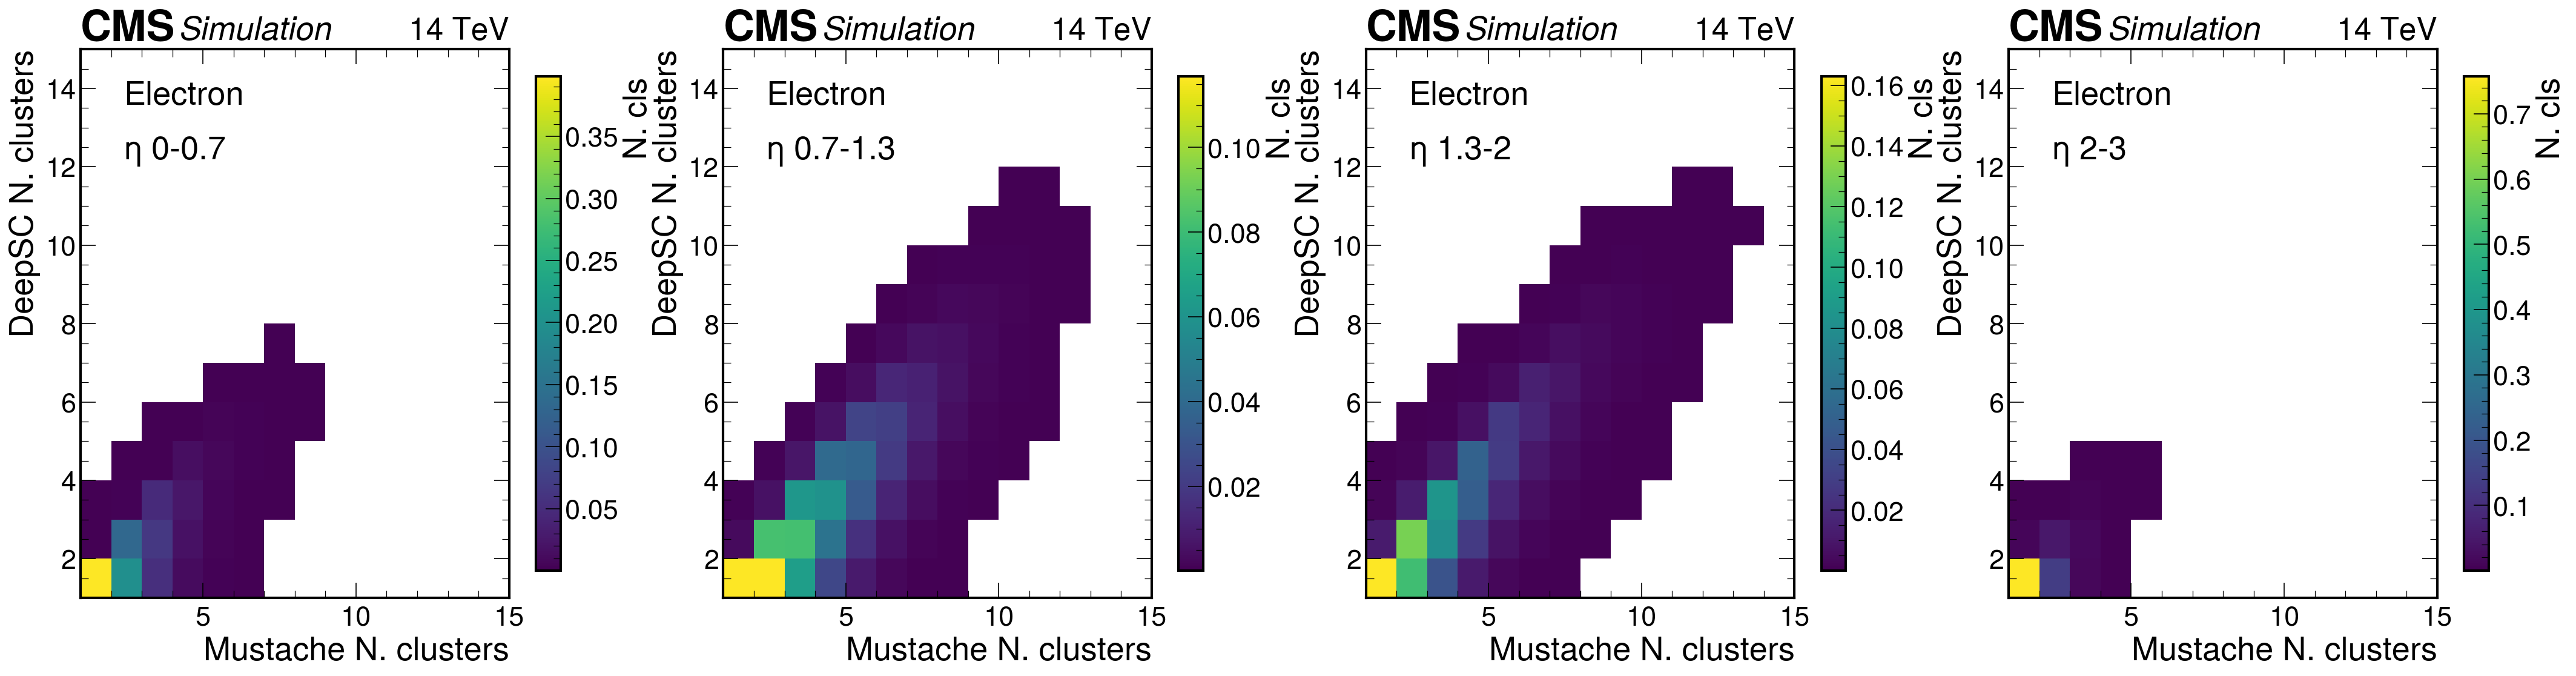

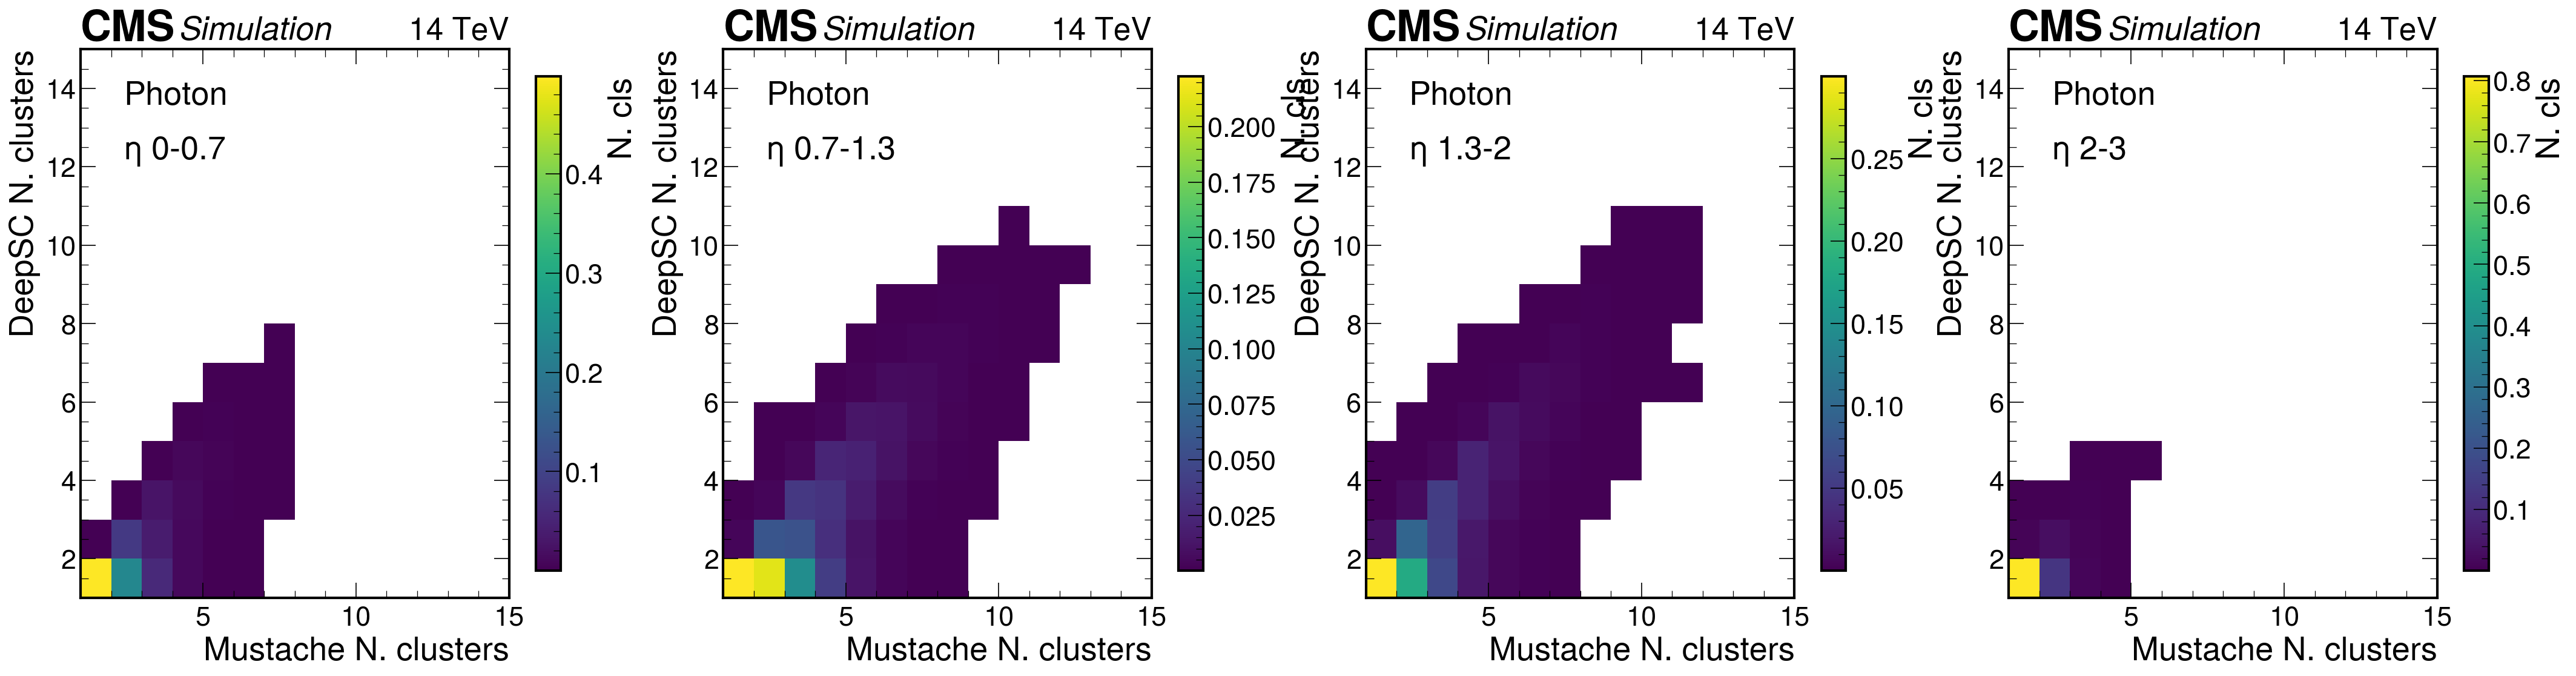

In [62]:
etas =  [0, 0.7, 1.3, 2, 3]


for df, flavour in zip ([df_ele_old, df_gamma_old], ["Electron","Photon"]):
    
    fig, ax = plt.subplots(1,len(etas)-1, figsize=(35,8),dpi=150)
    for i in range(len(etas)-1):
        mask = (df.seed_eta>etas[i]) & (df.seed_eta< etas[i+1])
        A = ax[i].hist2d(df[mask].ncls_sel_must, df[mask].ncls_sel, range=((1, 15), (1,15)), bins=(14,14), density=True, cmin=1e-4)
        hep.cms.label(rlabel="14 TeV", loc=0, ax=ax[i])
        ax[i].text(0.1, 0.8, "$\eta$ {}-{}".format(etas[i], etas[i+1]), transform=ax[i].transAxes)
        ax[i].text(0.1, 0.9, flavour, transform=ax[i].transAxes)

        fig.colorbar(A[3] , label="N. cls", ax=ax[i], shrink=0.9)

        ax[i].set_xlabel("Mustache N. clusters")
        ax[i].set_ylabel("DeepSC N. clusters")


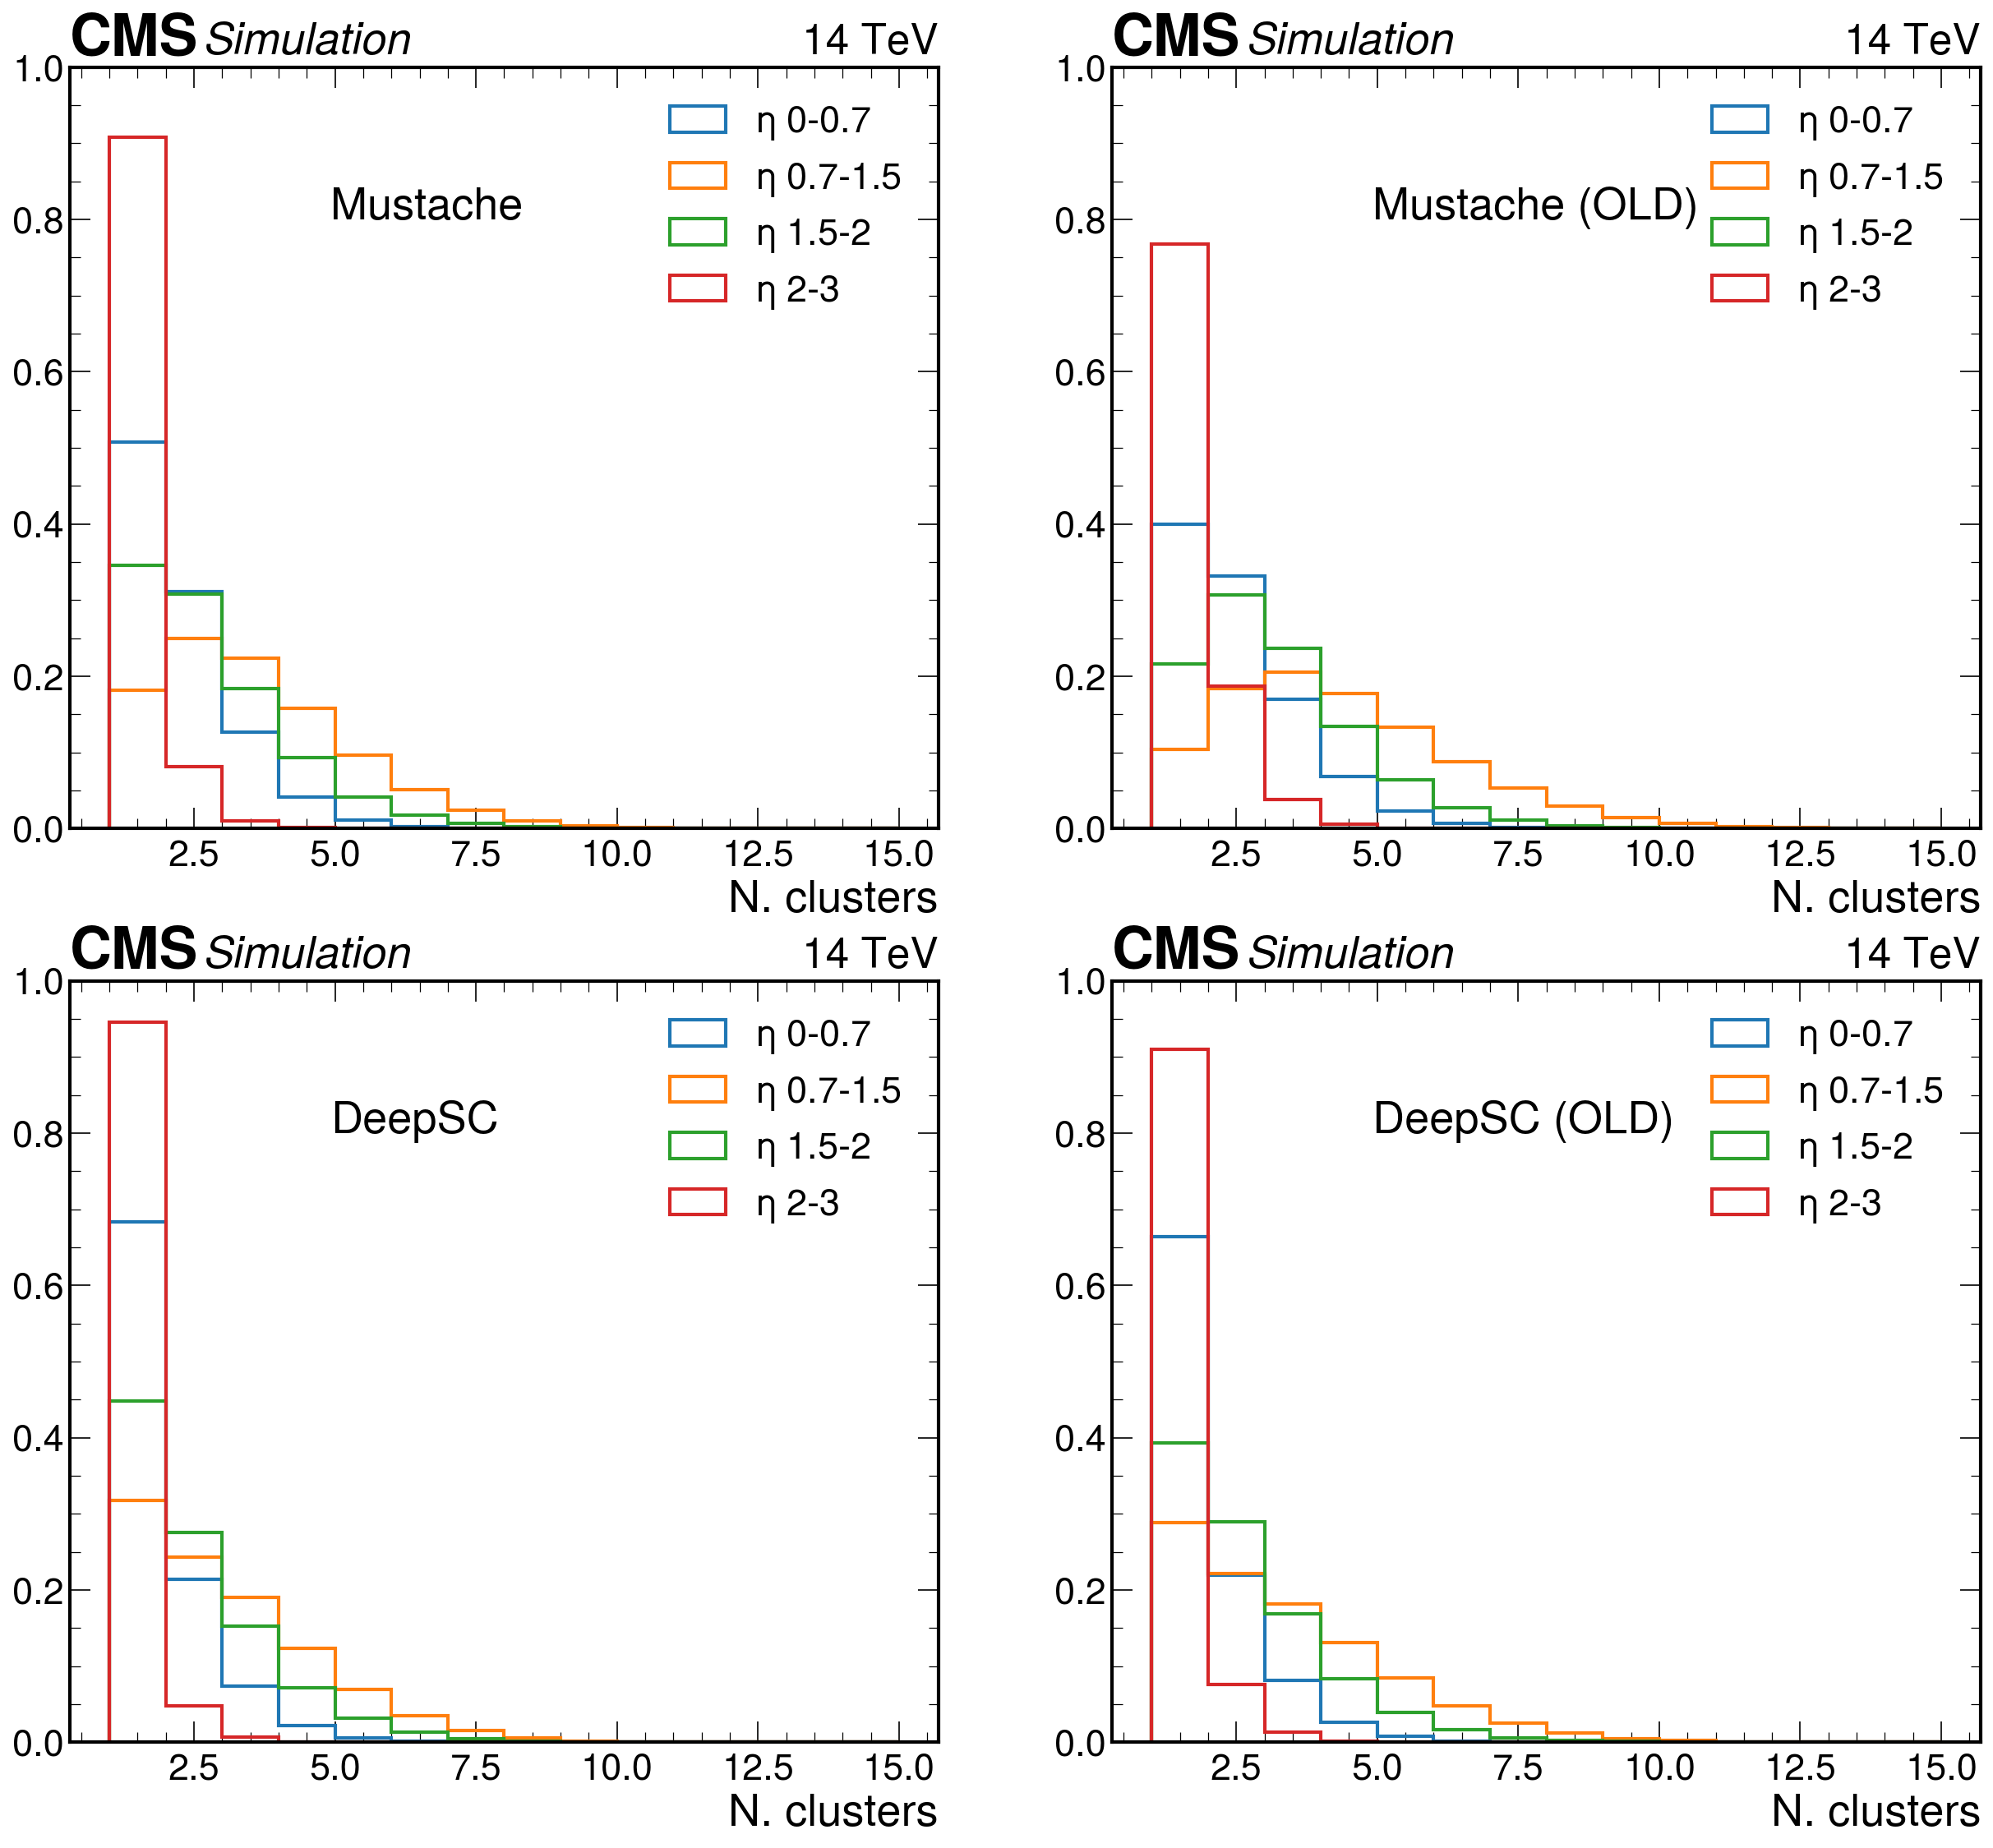

In [72]:
etas = [0, 0.7, 1.5, 2, 3]

fig, ax = plt.subplots(2,2, figsize=(20,18),dpi=150)

for df, flavour in zip ([df_ele], ["Electron"]):
    
    for i in range(len(etas)-1):
        mask = (df.eta>etas[i]) & (df.eta< etas[i+1]) & (df.calo_et_true_gen > 5)
        A = ax[0][0].hist(df[mask].mustache_ncls, range=(1,15), bins=14, density=True, histtype="step", label="$\eta$ {}-{}".format(etas[i], etas[i+1]), linewidth=2)
        A = ax[1][0].hist(df[mask].deepsc_ncls, range=(1,15), bins=14, density=True, histtype="step", label="$\eta$ {}-{}".format(etas[i], etas[i+1]), linewidth=2)

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax[0][0])
    ax[0][0].text(0.3, 0.8, "Mustache", transform=ax[0][0].transAxes)
    ax[0][0].legend()
    ax[0][0].set_xlabel("N. clusters")
    ax[0][0].set_ylim(0, 1)

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax[1][0])
    ax[1][0].text(0.3, 0.8, "DeepSC", transform=ax[1][0].transAxes)
    ax[1][0].legend()
    ax[1][0].set_xlabel("N. clusters")
    ax[1][0].set_ylim(0, 1)
    
for df, flavour in zip ([df_ele_old], ["Electron OLD"]):
    
    for i in range(len(etas)-1):
        mask = (df.seed_eta>etas[i]) & (df.seed_eta< etas[i+1]) &  (df.et_true_gen > 5)
        A = ax[0][1].hist(df[mask].ncls_sel_must, range=(1,15), bins=14, density=True, histtype="step", label="$\eta$ {}-{}".format(etas[i], etas[i+1]), linewidth=2)
        A = ax[1][1].hist(df[mask].ncls_sel, range=(1,15), bins=14, density=True, histtype="step", label="$\eta$ {}-{}".format(etas[i], etas[i+1]), linewidth=2)

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax[0][1])
    ax[0][1].text(0.3, 0.8, "Mustache (OLD)", transform=ax[0][1].transAxes)
    ax[0][1].legend()
    ax[0][1].set_xlabel("N. clusters")
    ax[0][1].set_ylim(0, 1)

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax[1][1])
    ax[1][1].text(0.3, 0.8, "DeepSC (OLD)", transform=ax[1][1].transAxes)
    ax[1][1].legend()
    ax[1][1].set_xlabel("N. clusters")
    ax[1][1].set_ylim(0, 1)

/tmp/ipykernel_1118/2395381242.py:14: RuntimeWarning: invalid value encountered in true_divide
  R = (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/2395381242.py:14: RuntimeWarning: invalid value encountered in true_divide
  R = (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/2395381242.py:14: RuntimeWarning: invalid value encountered in true_divide
  R = (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/2395381242.py:24: RuntimeWarning: divide by zero encountered in true_divide
  R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/2395381242.py:24: RuntimeWarning: invalid value encountered in true_divide
  R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/2395381242.py:24: RuntimeWarning: divide by zero encountered in true_divide
  R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/239538124

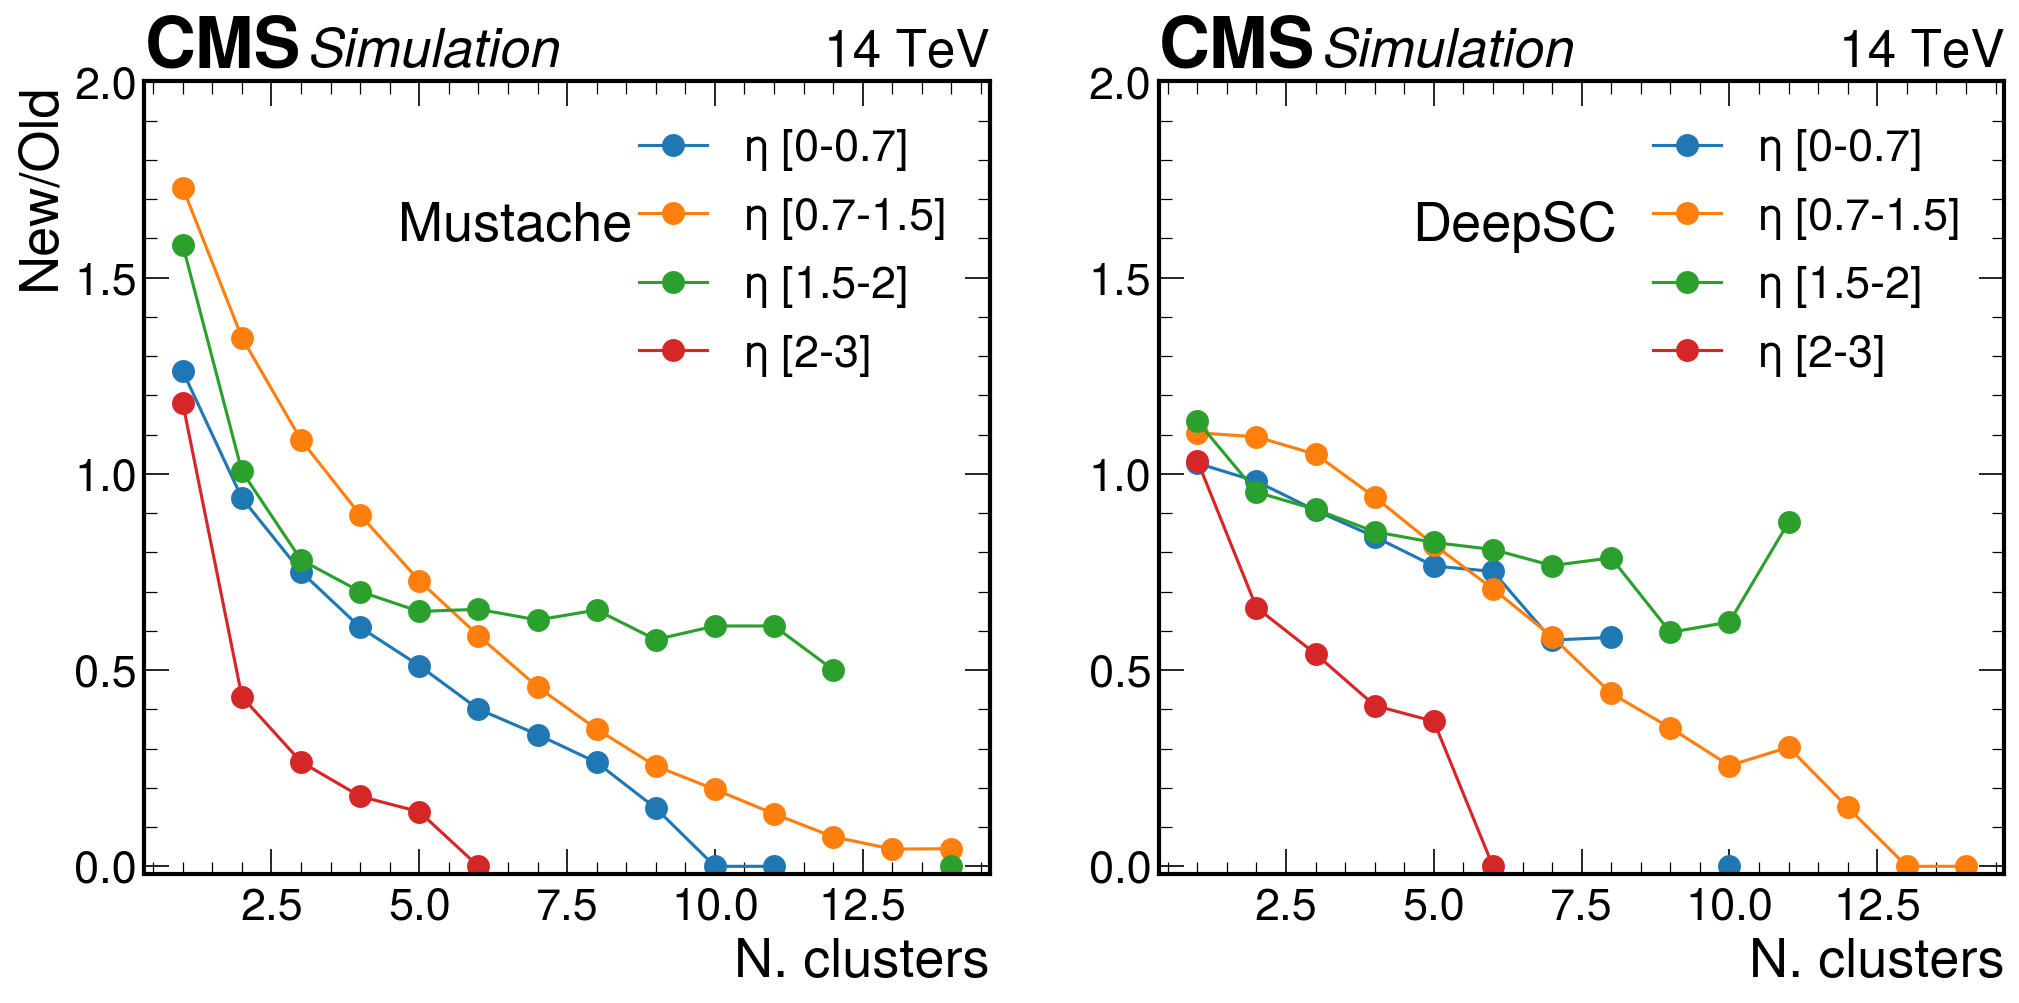

In [101]:
etas = [0, 0.7, 1.5, 2, 3]

fig, (ax, ay) = plt.subplots(1,2, figsize=(16,7),dpi=150)

for df, df_old, flavour in zip ([df_ele], [df_ele_old], ["Electron"]):
    
    for i in range(len(etas)-1):
        mask = (df.eta.abs()>etas[i]) & (df.eta.abs()< etas[i+1]) & (df.calo_et_true_gen > 5)
        mask_old = (df_old.seed_eta.abs()>etas[i]) & (df_old.seed_eta.abs()< etas[i+1]) & (df_old.et_true_gen > 5)
        
        M_new = np.histogram(df[mask].mustache_ncls, range=(1,15), bins=14)
        M_old = np.histogram(df_old[mask_old].ncls_sel_must, range=(1,15), bins=14)
        
        R = (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
        ax.plot(M_new[1][:-1], R, label="$\eta$ [{}-{}]".format(etas[i], etas[i+1]), marker='o', markersize=10)
        
    for i in range(len(etas)-1):
        mask = (df.eta.abs()>etas[i]) & (df.eta.abs()< etas[i+1]) & (df.calo_et_true_gen > 5)
        mask_old = (df_old.seed_eta.abs()>etas[i]) & (df_old.seed_eta.abs()< etas[i+1]) & (df_old.et_true_gen > 5)
        
        M_new = np.histogram(df[mask].deepsc_ncls, range=(1,15), bins=14)
        M_old = np.histogram(df_old[mask_old].ncls_sel, range=(1,15), bins=14)
        
        R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
        ay.plot(M_new[1][:-1], R, label="$\eta$ [{}-{}]".format(etas[i], etas[i+1]), marker='o', markersize=10)
        
        

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax)
    ax.text(0.3, 0.8, "Mustache", transform=ax.transAxes)
    ax.legend()
    ax.set_xlabel("N. clusters")
    ax.set_ylabel("New/Old")
    ax.set_ylim(-0.02, 2)                                       

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ay)
    ay.text(0.3, 0.8, "DeepSC", transform=ay.transAxes)
    ay.legend()
    ay.set_xlabel("N. clusters")
    ax.set_ylabel("New/Old")
    ay.set_ylim(-0.02, 2)


/tmp/ipykernel_1118/891815951.py:24: RuntimeWarning: invalid value encountered in true_divide
  R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/891815951.py:24: RuntimeWarning: divide by zero encountered in true_divide
  R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/891815951.py:24: RuntimeWarning: invalid value encountered in true_divide
  R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
/tmp/ipykernel_1118/891815951.py:24: RuntimeWarning: invalid value encountered in true_divide
  R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))


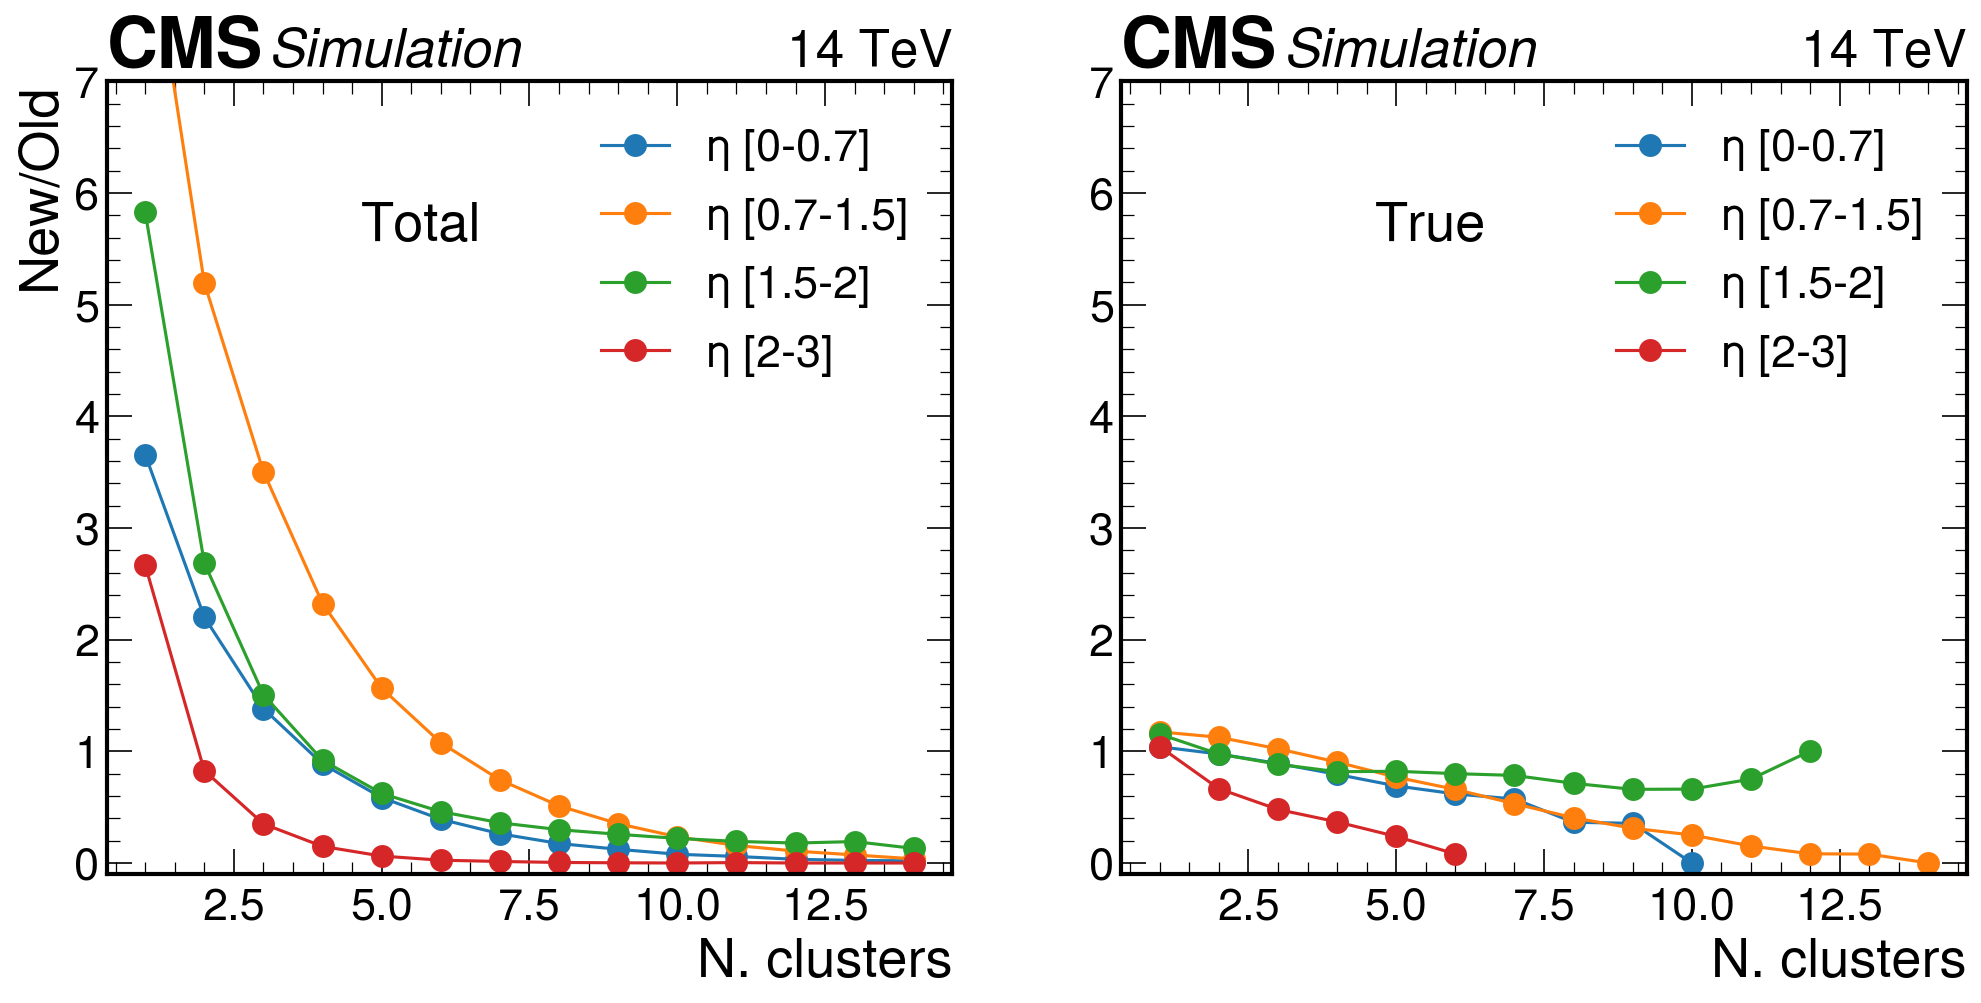

In [125]:
etas = [0, 0.7, 1.5, 2, 3]

fig, (ax, ay) = plt.subplots(1,2, figsize=(16,7),dpi=150)

for df, df_old, flavour in zip ([df_ele], [df_ele_old], ["Electron"]):
    
    for i in range(len(etas)-1):
        mask = (df.eta.abs()>etas[i]) & (df.eta.abs()< etas[i+1]) & (df.calo_et_true_gen > 5)
        mask_old = (df_old.seed_eta.abs()>etas[i]) & (df_old.seed_eta.abs()< etas[i+1]) & (df_old.et_true_gen > 5)
        
        M_new = np.histogram(df[mask].ncls_tot, range=(1,15), bins=14)
        M_old = np.histogram(df_old[mask_old].ncls, range=(1,15), bins=14)
        
        R = (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
        ax.plot(M_new[1][:-1], R, label="$\eta$ [{}-{}]".format(etas[i], etas[i+1]), marker='o', markersize=10)
        
    for i in range(len(etas)-1):
        mask = (df.eta.abs()>etas[i]) & (df.eta.abs()< etas[i+1]) & (df.calo_et_true_gen > 5)
        mask_old = (df_old.seed_eta.abs()>etas[i]) & (df_old.seed_eta.abs()< etas[i+1]) & (df_old.et_true_gen > 5)
        
        M_new = np.histogram(df[mask].ncls_true, range=(1,15), bins=14)
        M_old = np.histogram(df_old[mask_old].ncls_true, range=(1,15), bins=14)
        
        R =  (M_new[0]/np.sum(M_new[0]) ) /( M_old[0]/ np.sum(M_old[0]))
        ay.plot(M_new[1][:-1], R, label="$\eta$ [{}-{}]".format(etas[i], etas[i+1]), marker='o', markersize=10)
        
        

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax)
    ax.text(0.3, 0.8, "Total", transform=ax.transAxes)
    ax.legend()
    ax.set_xlabel("N. clusters")
    ax.set_ylabel("New/Old")
    ax.set_ylim(-0.1, 7)                                       

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ay)
    ay.text(0.3, 0.8, "True", transform=ay.transAxes)
    ay.legend()
    ay.set_xlabel("N. clusters")
    ax.set_ylabel("New/Old")
    ay.set_ylim(-0.1, 7)


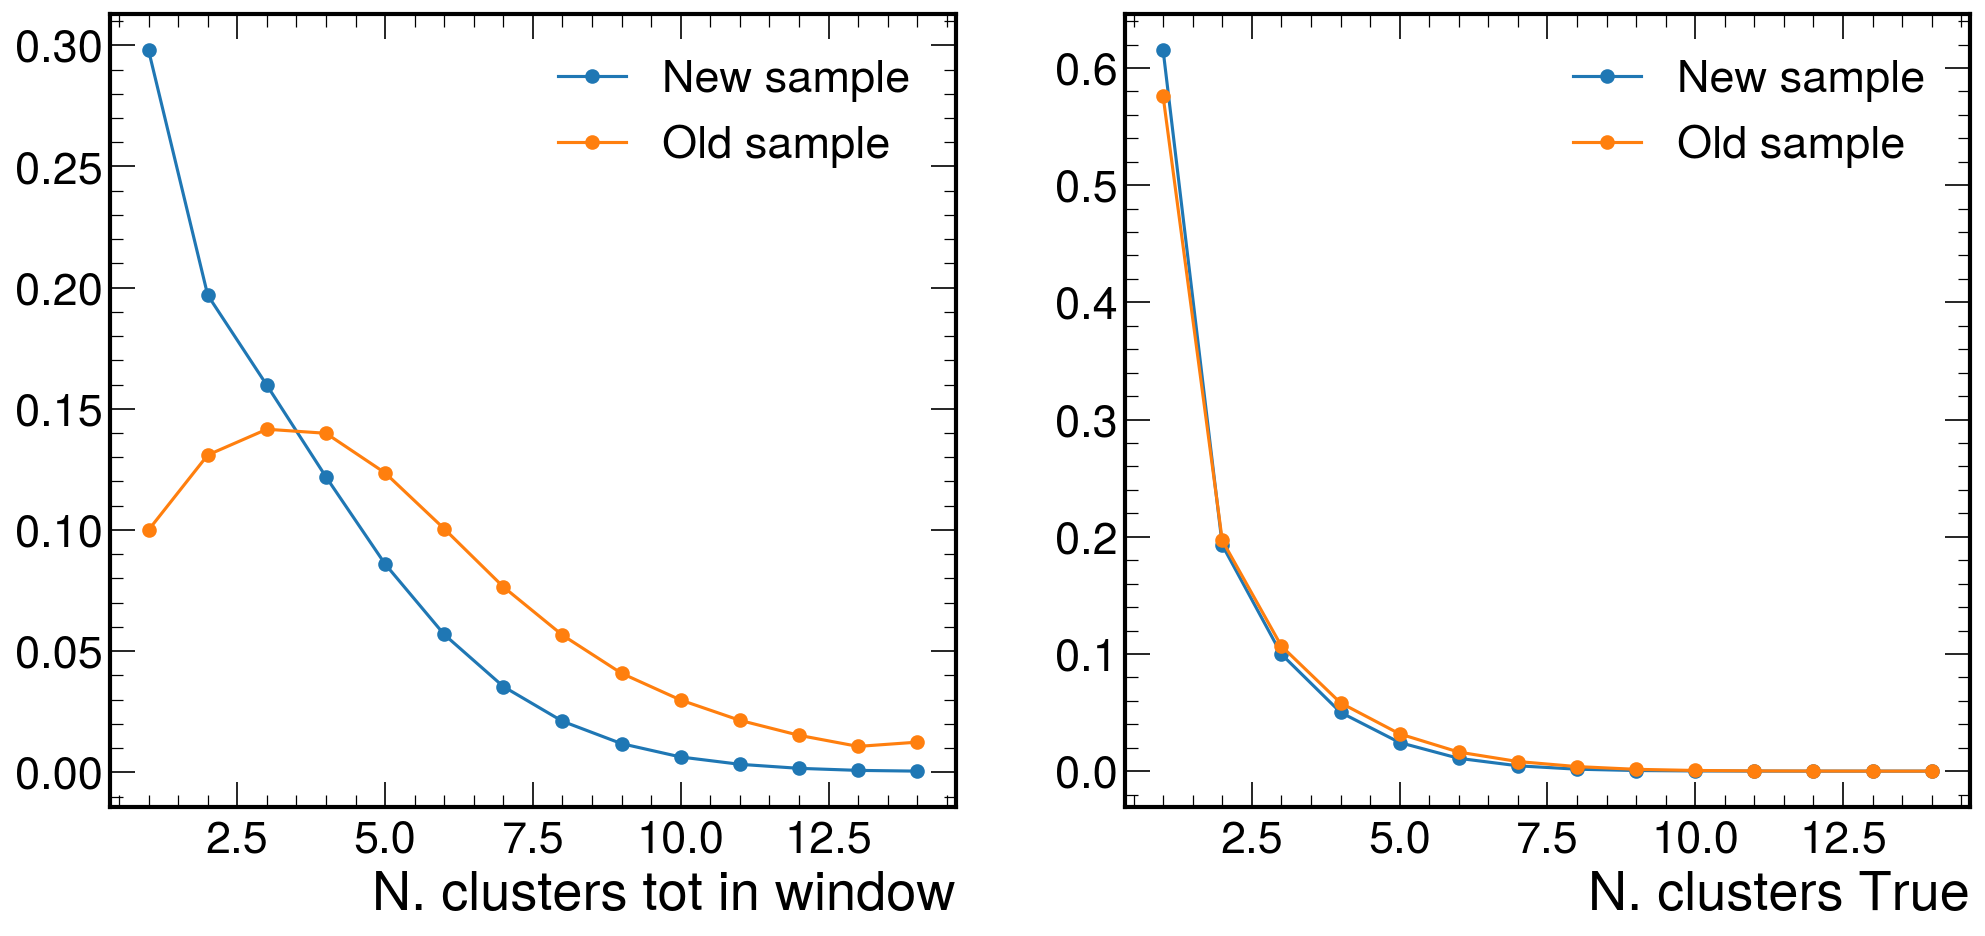

In [122]:
fig, (ax, ay) = plt.subplots(1,2, figsize=(16,7),dpi=150)

mask = df_ele.et_seed > 5
mask_o = df_ele_old.et_seed > 5

A = np.histogram(df_ele[mask].ncls_tot,bins=14, range=(1,15) )
ax.plot(A[1][:-1], A[0]/np.sum(A[0]), marker="o", label="New sample")
B = np.histogram(df_ele_old[mask_o].ncls,bins=14, range=(1,15) )
ax.plot(B[1][:-1], B[0]/np.sum(B[0]), marker="o", label="Old sample")

ax.set_xlabel("N. clusters tot in window")
ax.legend()


A = np.histogram(df_ele[mask].ncls_true,bins=14, range=(1,15) )
ay.plot(A[1][:-1], A[0]/np.sum(A[0]), marker="o", label="New sample")
B = np.histogram(df_ele_old[mask_o].ncls_true,bins=14, range=(1,15) )
ay.plot(B[1][:-1], B[0]/np.sum(B[0]), marker="o", label="Old sample")

ay.set_xlabel("N. clusters True")
ay.legend()

## Resolution


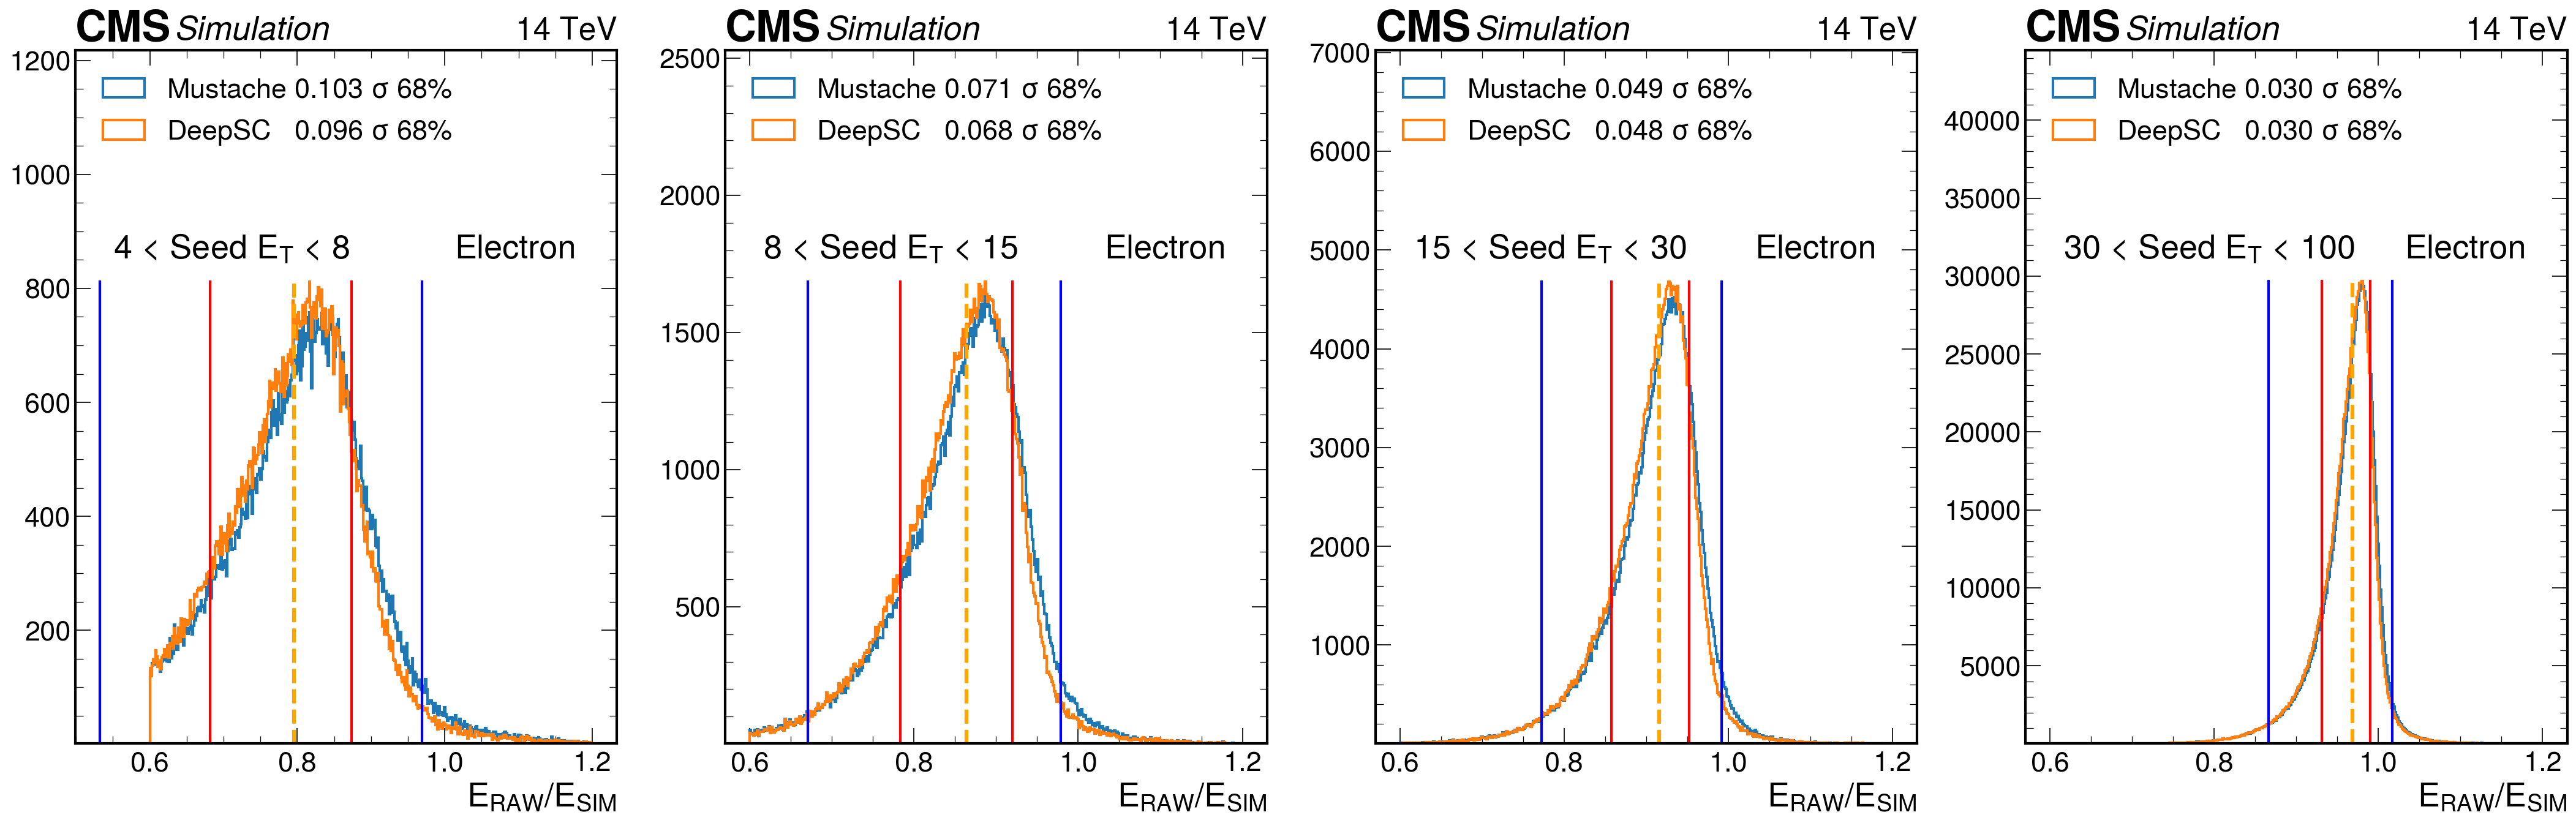

In [51]:

fig, ax = plt.subplots(1,4, figsize=(35,10),dpi=150)
flavour = "Electron"
xrange = (0.6, 1.2)
bins= 400

r = [4,8,15,30, 100]
s = [[]]
for i in range(len(r)-1):
    line = i //4 
    s[line].append((r[i],r[i+1]))

for j,ss in enumerate(s): 
    for i, (e1,e2) in enumerate(ss): 
        dfx = df[(abs(df.et_seed)>=e1) & (abs(df.et_seed)<e2)]

        width, width_2 = get_sigma_eff(dfx.En_ovEtrue_deepsc)
        width_must, width_2_must = get_sigma_eff(dfx.En_ovEtrue_mustache)

        a,b,c,d,e = get_quantiles(dfx.En_ovEtrue_deepsc)


        ax[i].hist(dfx.En_ovEtrue_mustache,bins=bins, range=xrange,histtype='step', linewidth=2, label='Mustache {:.3f} $\sigma$ 68%'.format(width_must))
        A= ax[i].hist(dfx.En_ovEtrue_deepsc,bins=bins, range=xrange,histtype='step', linewidth=2, label='DeepSC   {:.3f} $\sigma$ 68%'.format(width))
#         ax[j,i].hist(dfx.En_ovEtrue_gen_corr,bins=bins, range=xrange,histtype='step', linewidth=2, label='DeepSC +regre    RMS: {:.4f}'.format(rms_regr))


        maxY = np.max(A[0])

        ax[i].plot([a,a],[0,maxY], color="blue", linewidth=2)
        ax[i].plot([e,e],[0,maxY], color="blue", linewidth=2)
        ax[i].plot([b,b],[0,maxY], color="red", linewidth=2)
        ax[i].plot([d,d],[0,maxY], color="red", linewidth=2)
        ax[i].plot([c,c],[0,maxY], color="orange", linewidth=3, linestyle='dashed')

        ax[i].legend(loc="upper left")
#         ax[j,i].set_yscale('log')
        ax[i].set_ylim(1, 1.5 * maxY)
        ax[i].set_xlabel("$E_{RAW}/E_{SIM}$")
        ax[i].text(0.07,0.7,  str(e1) + ' < Seed $E_T$ < ' + str(e2), transform = ax[i].transAxes)  
        ax[i].text(0.7, 0.7, flavour, transform=ax[i].transAxes)

        hep.cms.label(rlabel='14 TeV',loc=0, ax=ax[i])


# Resolution by Gen ET 

/tmp/ipykernel_1118/2485917726.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_1118/2485917726.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["eta_bin"] = pd.cut(abs(df.calo_simeta), etas, labels=list(range(len(etas)-1)))
/tmp/ipykernel_1118/2485917726.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

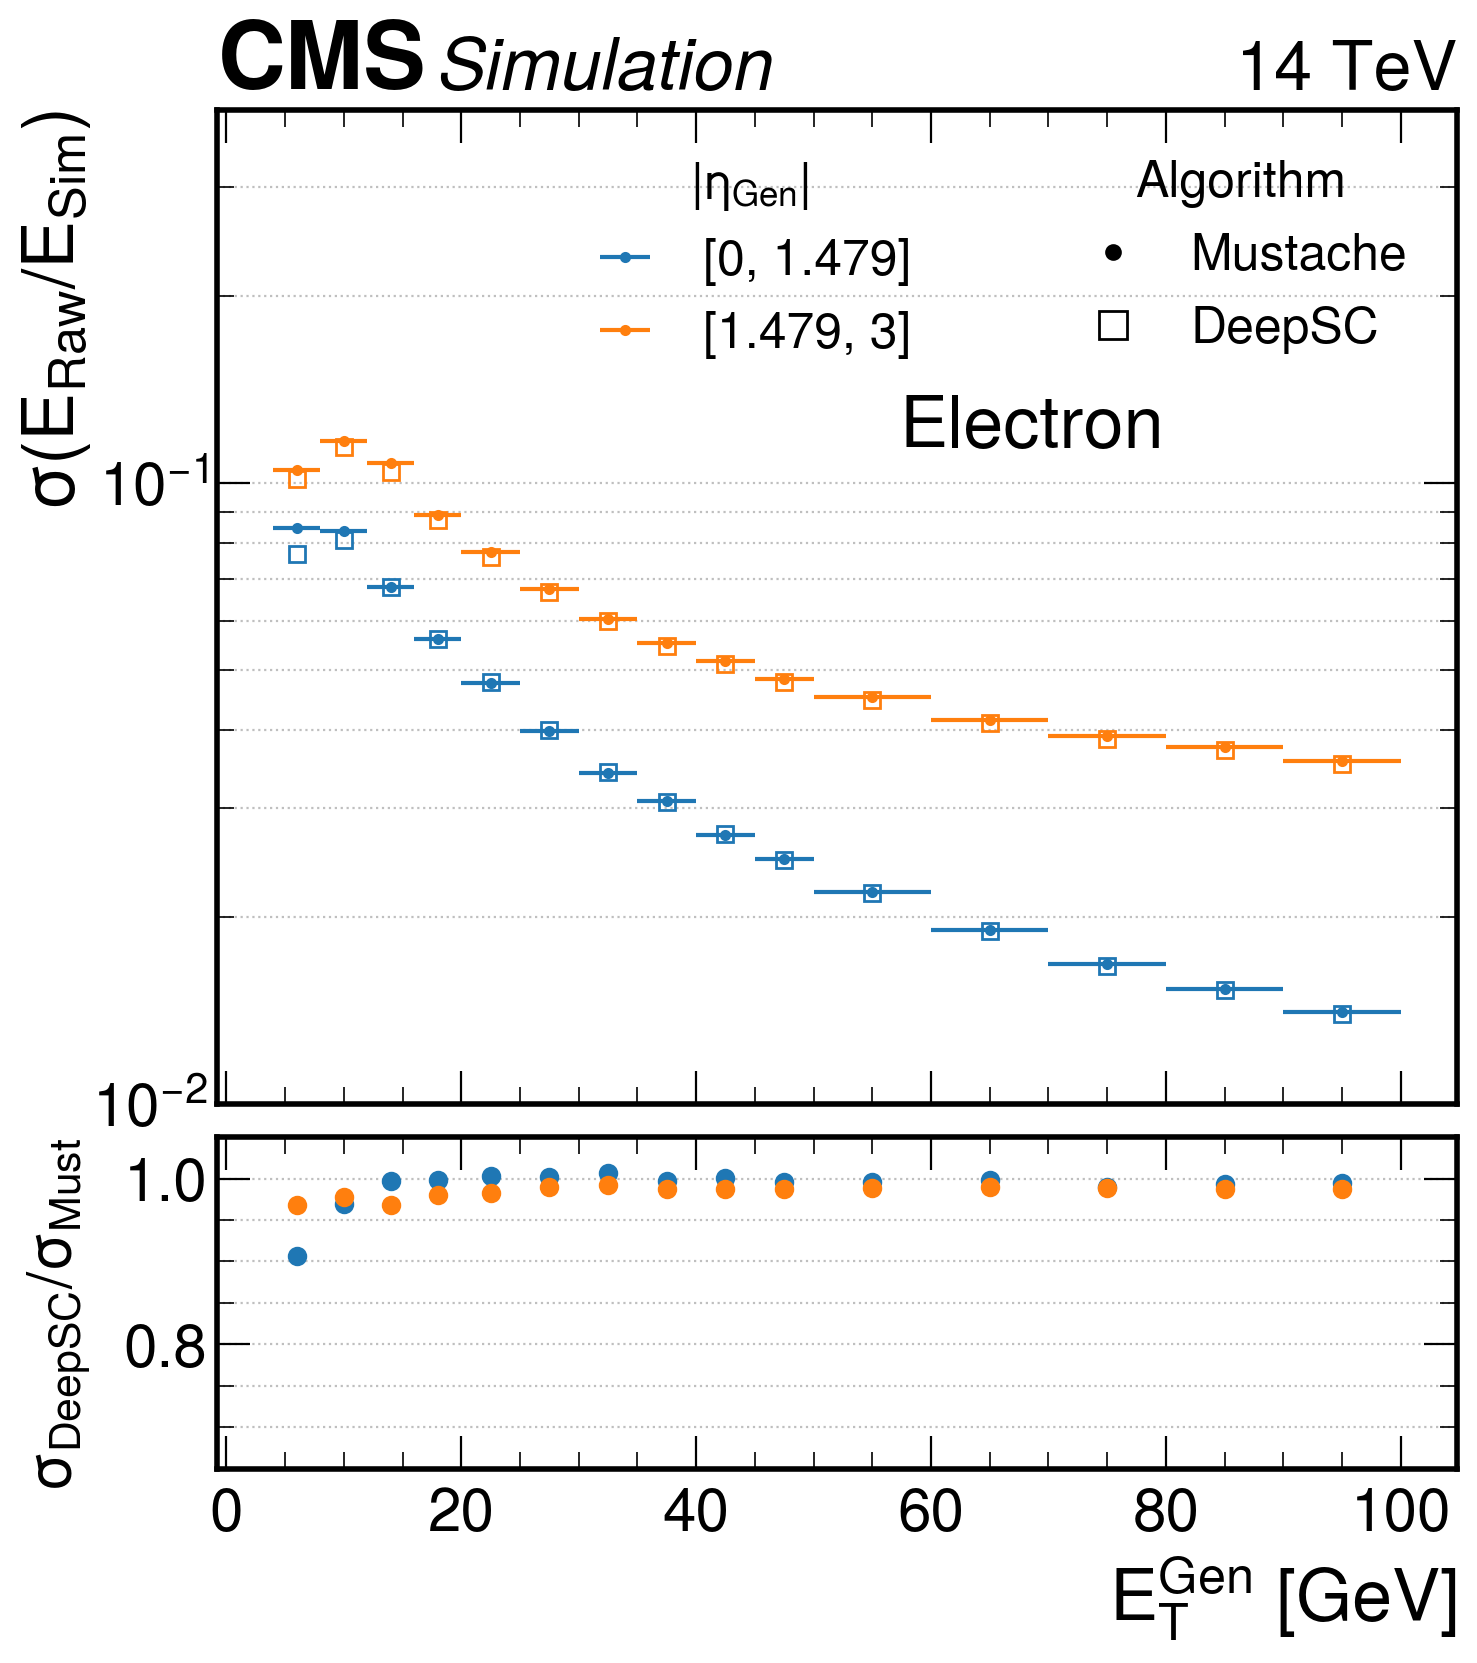

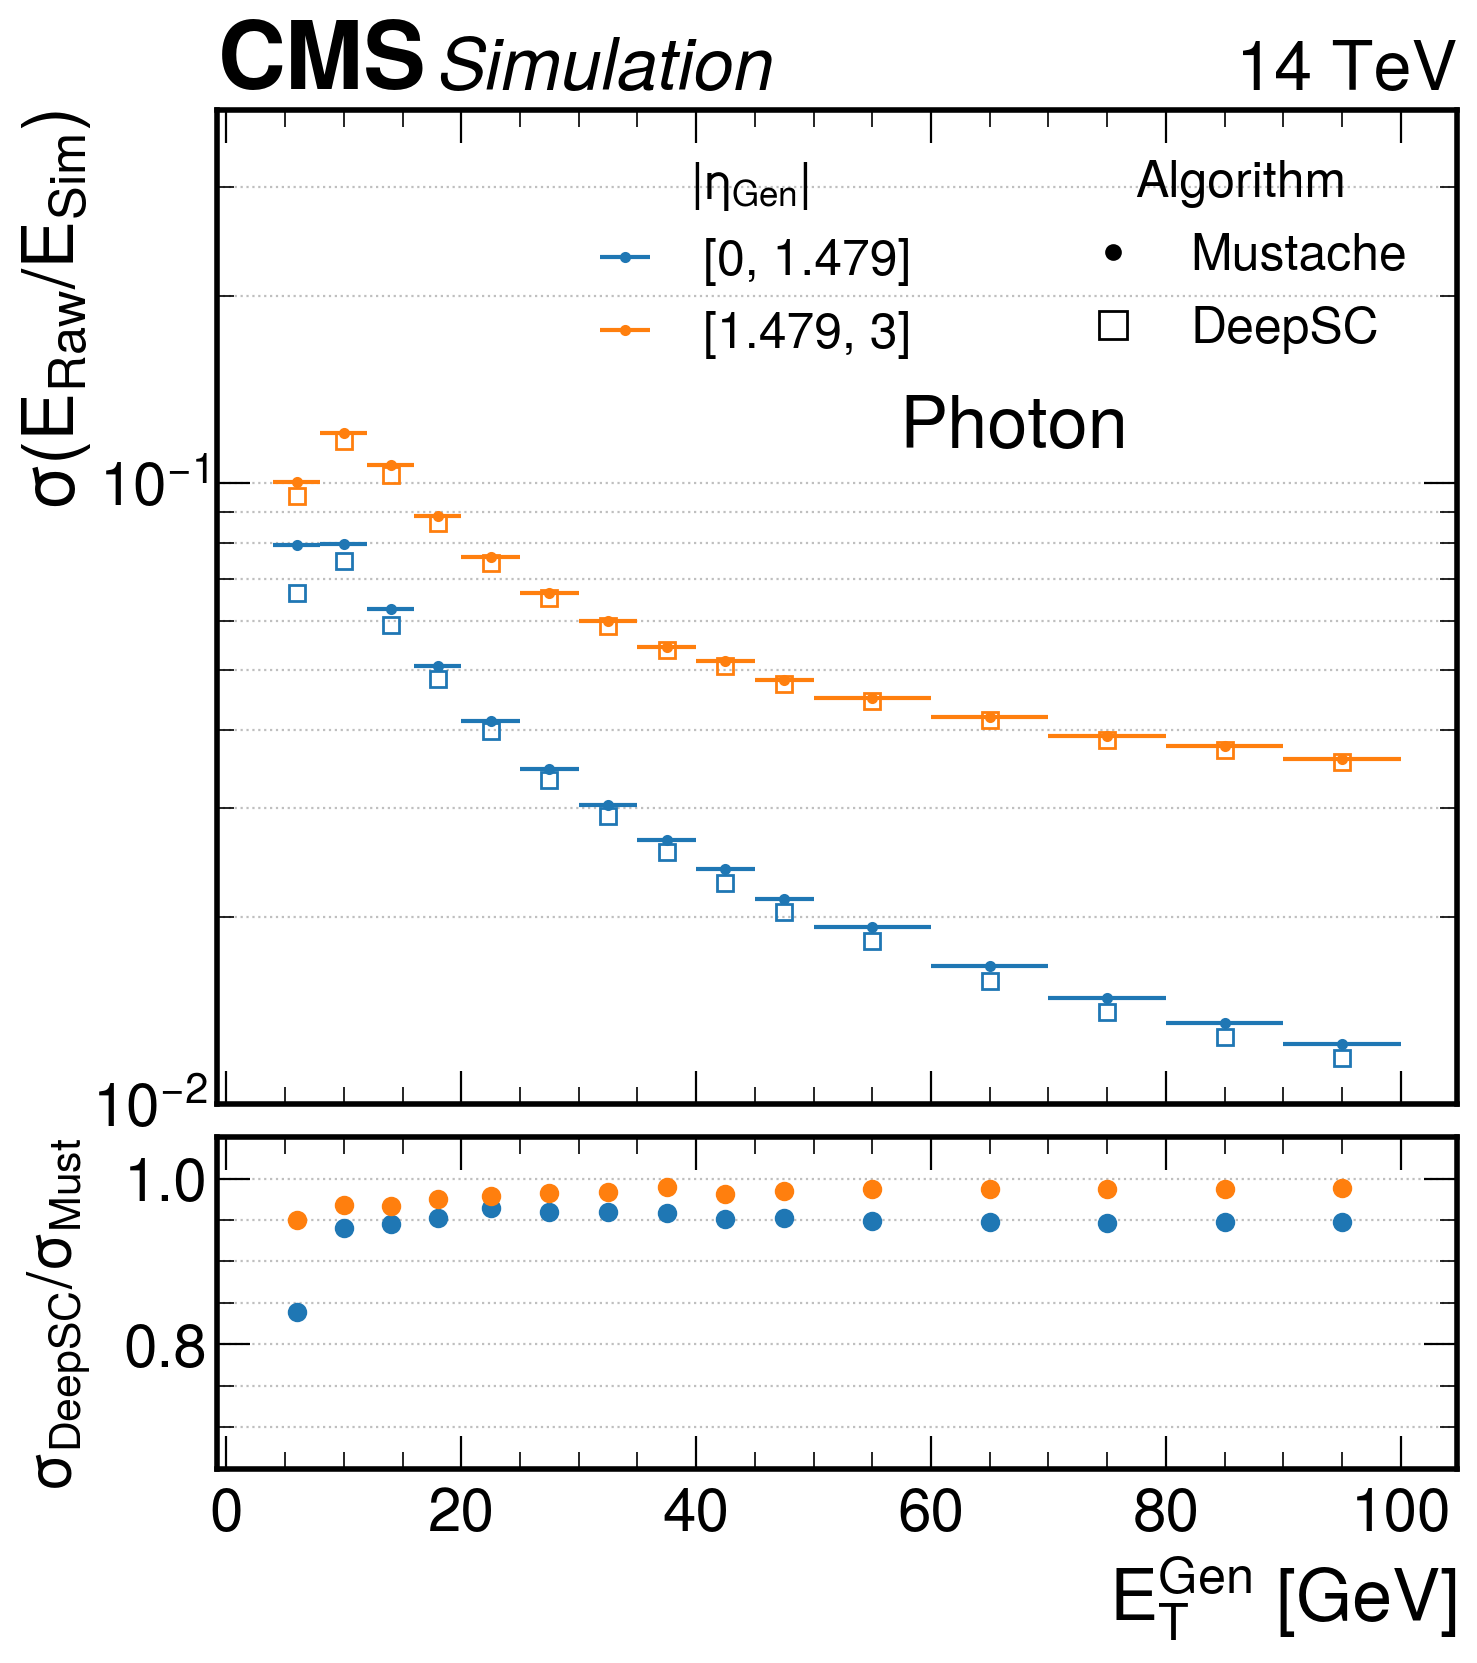

In [126]:
dfs = [df_ele, df_gamma]
flavours = ["Electron", "Photon"]

for df,flavour in zip(dfs, flavours):
#     ets = [1.5, 3,4,5, 6,8, 10,15,20,40,60, 80,100]
    ets = [4, 8, 12,16, 20,25 ,30,35,40, 45, 50, 60, 70, 80, 90 ,100]
    etas = [0, 1.479, 3]
    df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.calo_simeta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_deepsc"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)

    mustl = []
    deepl = []


        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res_must[res_must.eta_bin == ieta].w68, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt = ".")
        mustl.append(l)
        
    for ieta, eta in enumerate(etas[:-1]):
        l = axs[0].errorbar(x, res[res.eta_bin == ieta].w68, xerr=errx,label="[{}, {}]".format(etas[ieta], etas[ieta+1]), 
                                marker="s", markerfacecolor='none', c=mustl[ieta].lines[0].get_color(), linestyle='none', elinewidth=0)
        deepl.append(l)
    

    for ieta, eta in enumerate(etas[:-1]):
#         v =res_must[res_must.eta_bin == ieta].w68**2 - res[res.eta_bin == ieta].w68**2
#         var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.eta_bin == ieta].w68
        var = res[res.eta_bin == ieta].w68 / res_must[res_must.eta_bin == ieta].w68
        axs[1].errorbar(x, var, xerr=errx, label="[{}, {}]".format(etas[ieta], etas[ieta+1]), fmt="o", linestyle='none', elinewidth=0 )

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    axs[1].set_xlabel("$E_T^{Gen}$ [GeV]")
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")
    axs[0].set_ylim(1e-2, 0.4)
    axs[1].set_ylim(0.65, 1.05)
    axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
#     axs[1].legend(ncol=2, loc="upper right", fontsize=15)

    axs[0].text(0.55, 0.66, flavour, transform=axs[0].transAxes)
    axs[0].set_yscale("log")

    l1= axs[0].legend(handles=mustl, title="$|\eta_{Gen}|$", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.6, 1), fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", fontsize=18)
    axs[0].add_artist(l1)
    axs[1].grid(axis="y",which="both")
    axs[0].grid(axis="y", which="both")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byEnergy_{}_ratio.svg".format(flavour))

# Resolution by $\eta$

/tmp/ipykernel_1118/1600860217.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_1118/1600860217.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["eta_bin"] = pd.cut(abs(df.calo_simeta), etas, labels=list(range(len(etas)-1)))
/tmp/ipykernel_1118/1600860217.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

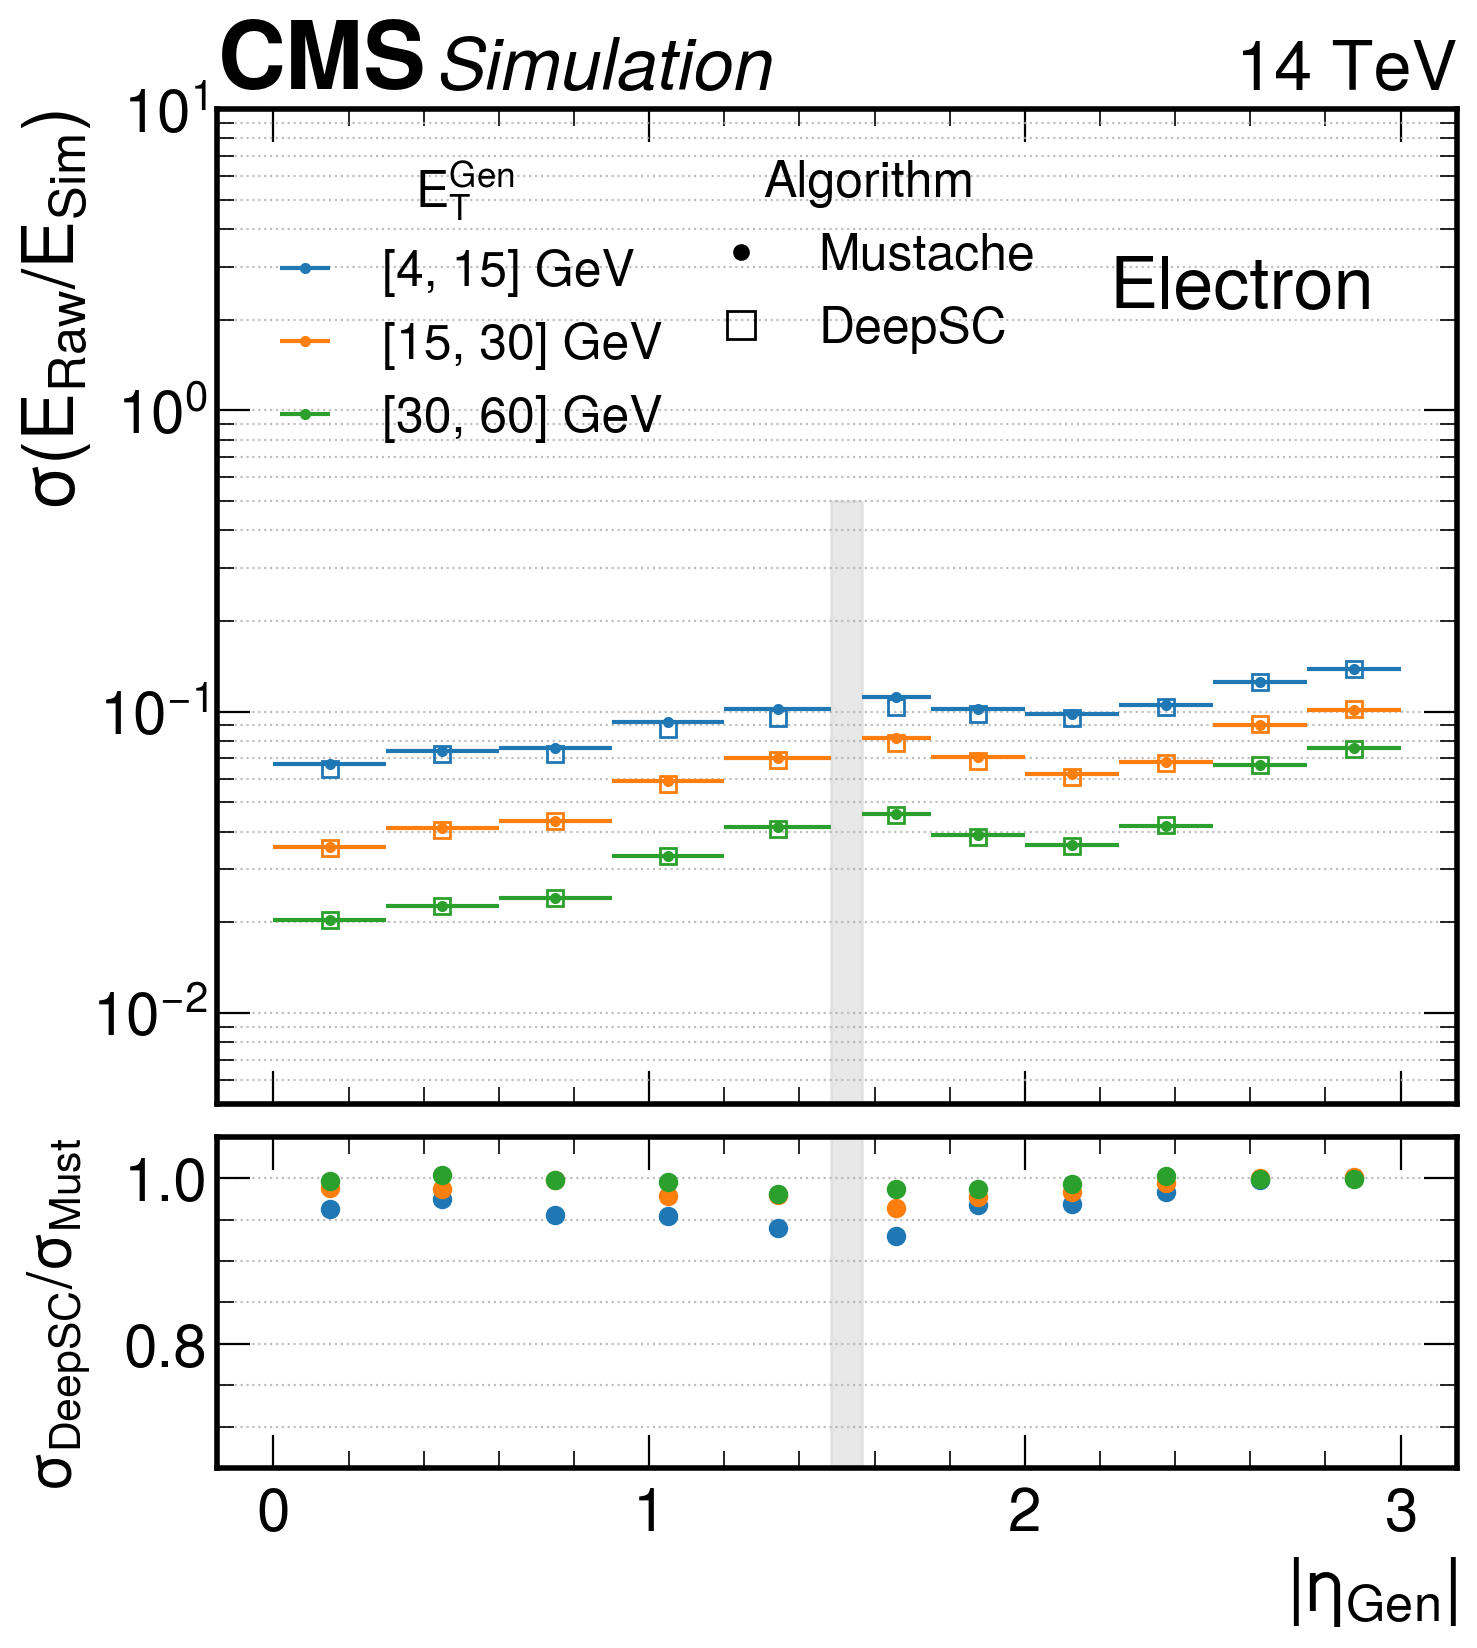

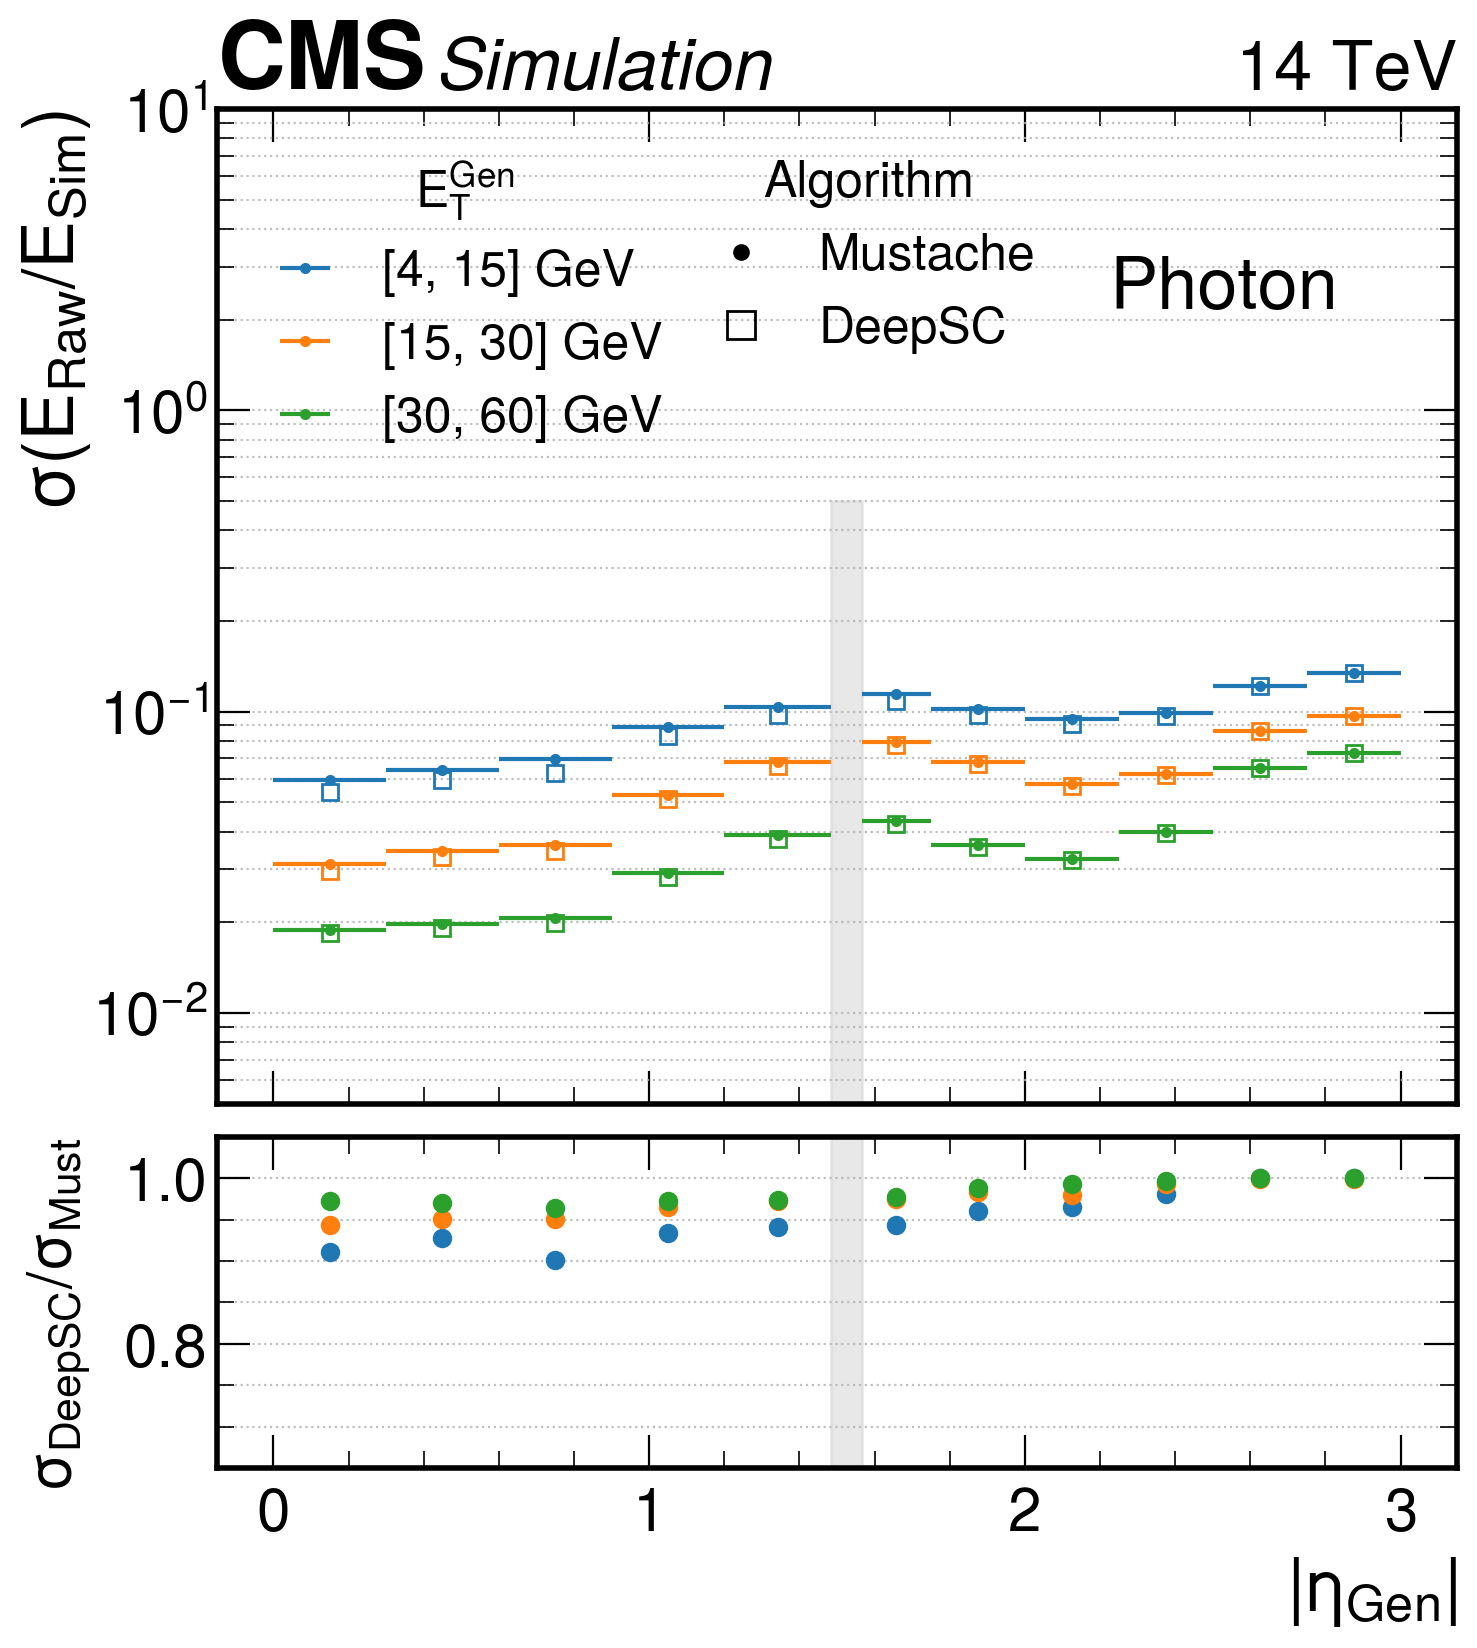

In [127]:
dfs = [df_ele, df_gamma]
flavours = ["Electron", "Photon"]

for df,flavour in zip(dfs, flavours):

    ets = [4,15,30,60]
    iplot = [0, 1, 2, 3 ]
    etas = [0, 0.3,0.6,0.9,1.2, 1.485, 1.566, 1.75, 2.,2.25,2.5,2.75,3]
    exclude_bin = 5
    df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["eta_bin"] = pd.cut(abs(df.calo_simeta), etas, labels=list(range(len(etas)-1)))


    res = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_deepsc"))
    res_must = df.groupby(["et_bin","eta_bin"]).apply(bin_analysis("En_ovEtrue_mustache"))
#     avgenraw = df.groupby(["et_bin","eta_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
#     avgenraw.reset_index(level=0, inplace=True)
    
    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    axs = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(etas)-1):
        errx.append((etas[i+1]- etas[i])/2)
        x.append((etas[i+1]+ etas[i])/2)

    mustl = []
    deepl = []
    
    res.loc[res.eta_bin == exclude_bin, ["w68"]] = 0
    res_must.loc[res_must.eta_bin == exclude_bin, ["w68"]] = 0
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)

    i = 0
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = axs[0].errorbar(x, res[res.et_bin == iet].w68,  xerr=errx ,label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), 
                                c=mustl[i].lines[0].get_color(), marker="s", markerfacecolor='none', linestyle='none',elinewidth=0)
        i+=1
        deepl.append(l)
        
    axs[0].fill_between([1.485, 1.566], [5e-3,5e-3],[0.5,0.5], color="lightgray", alpha=0.5)

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        #v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        #var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        var = res[res.et_bin==iet].w68 / res_must[res_must.et_bin==iet].w68
        axs[1].errorbar(x, var,xerr=errx, label="$E_T^{Gen} $" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),  fmt="o", linestyle='none', elinewidth=0)

    axs[0].set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")

    l1= axs[0].legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    axs[0].legend(handles=[ml,dl], title="Algorithm", title_fontsize=18, loc="upper right", bbox_to_anchor=(0.7, 1), fontsize=18)
    axs[0].add_artist(l1)

    axs[1].set_xlabel("$|\eta_{Gen}|$")
    axs[0].set_ylim(5e-3,1e1)
    # ax.plot([0,100],[1,1], linestyle="dashed", color="black")

    axs[1].set_ylim(0.65, 1.05)
    axs[1].set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    axs[0].get_yaxis().set_label_coords(-0.1,1)
    axs[1].get_yaxis().set_label_coords(-0.1,1)
    
    axs[1].fill_between([1.485, 1.566], [-0.1,-0.1],[1.1,1.1], color="lightgray", alpha=0.5)
      
#     axs[1].legend(ncol=3,prop={'size': 13}, loc="lower left" )

    axs[0].text(0.72, 0.8, flavour, transform=axs[0].transAxes)
    
    axs[0].set_yscale("log")
    axs[0].grid(which="both",axis="y")
    axs[1].grid(which="both",axis="y")

    hep.cms.label(rlabel="14 TeV", loc=0, ax=axs[0])
    
    fig.savefig(output_folder + "/resolution_byeta_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byeta_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byeta_{}_ratio.svg".format(flavour))

# Resolution by Number of clusters

/tmp/ipykernel_1118/2065535160.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_1118/2065535160.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ncls_bin"] = pd.cut(df.ncls_tot, ncls, labels=list(range(len(ncls)-1)))
/tmp/ipykernel_1118/2065535160.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

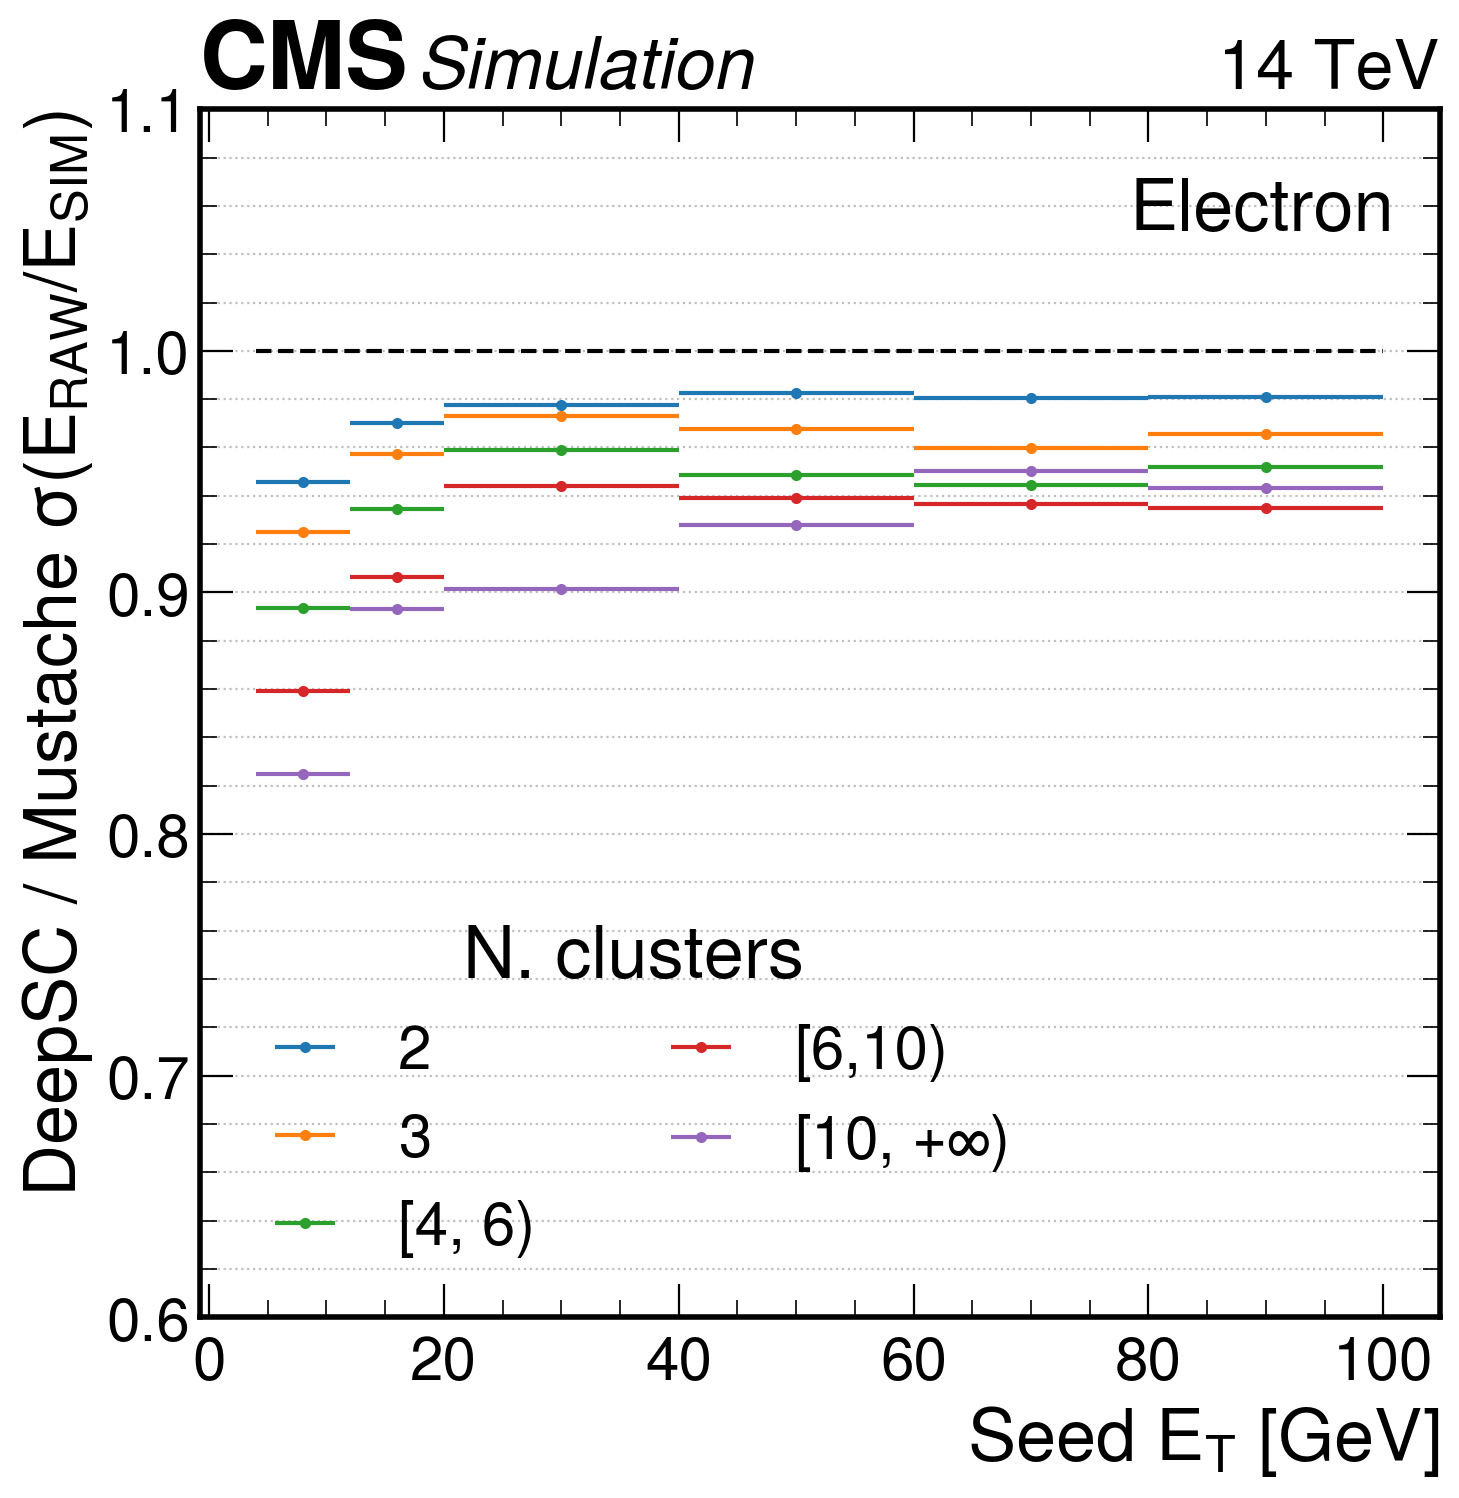

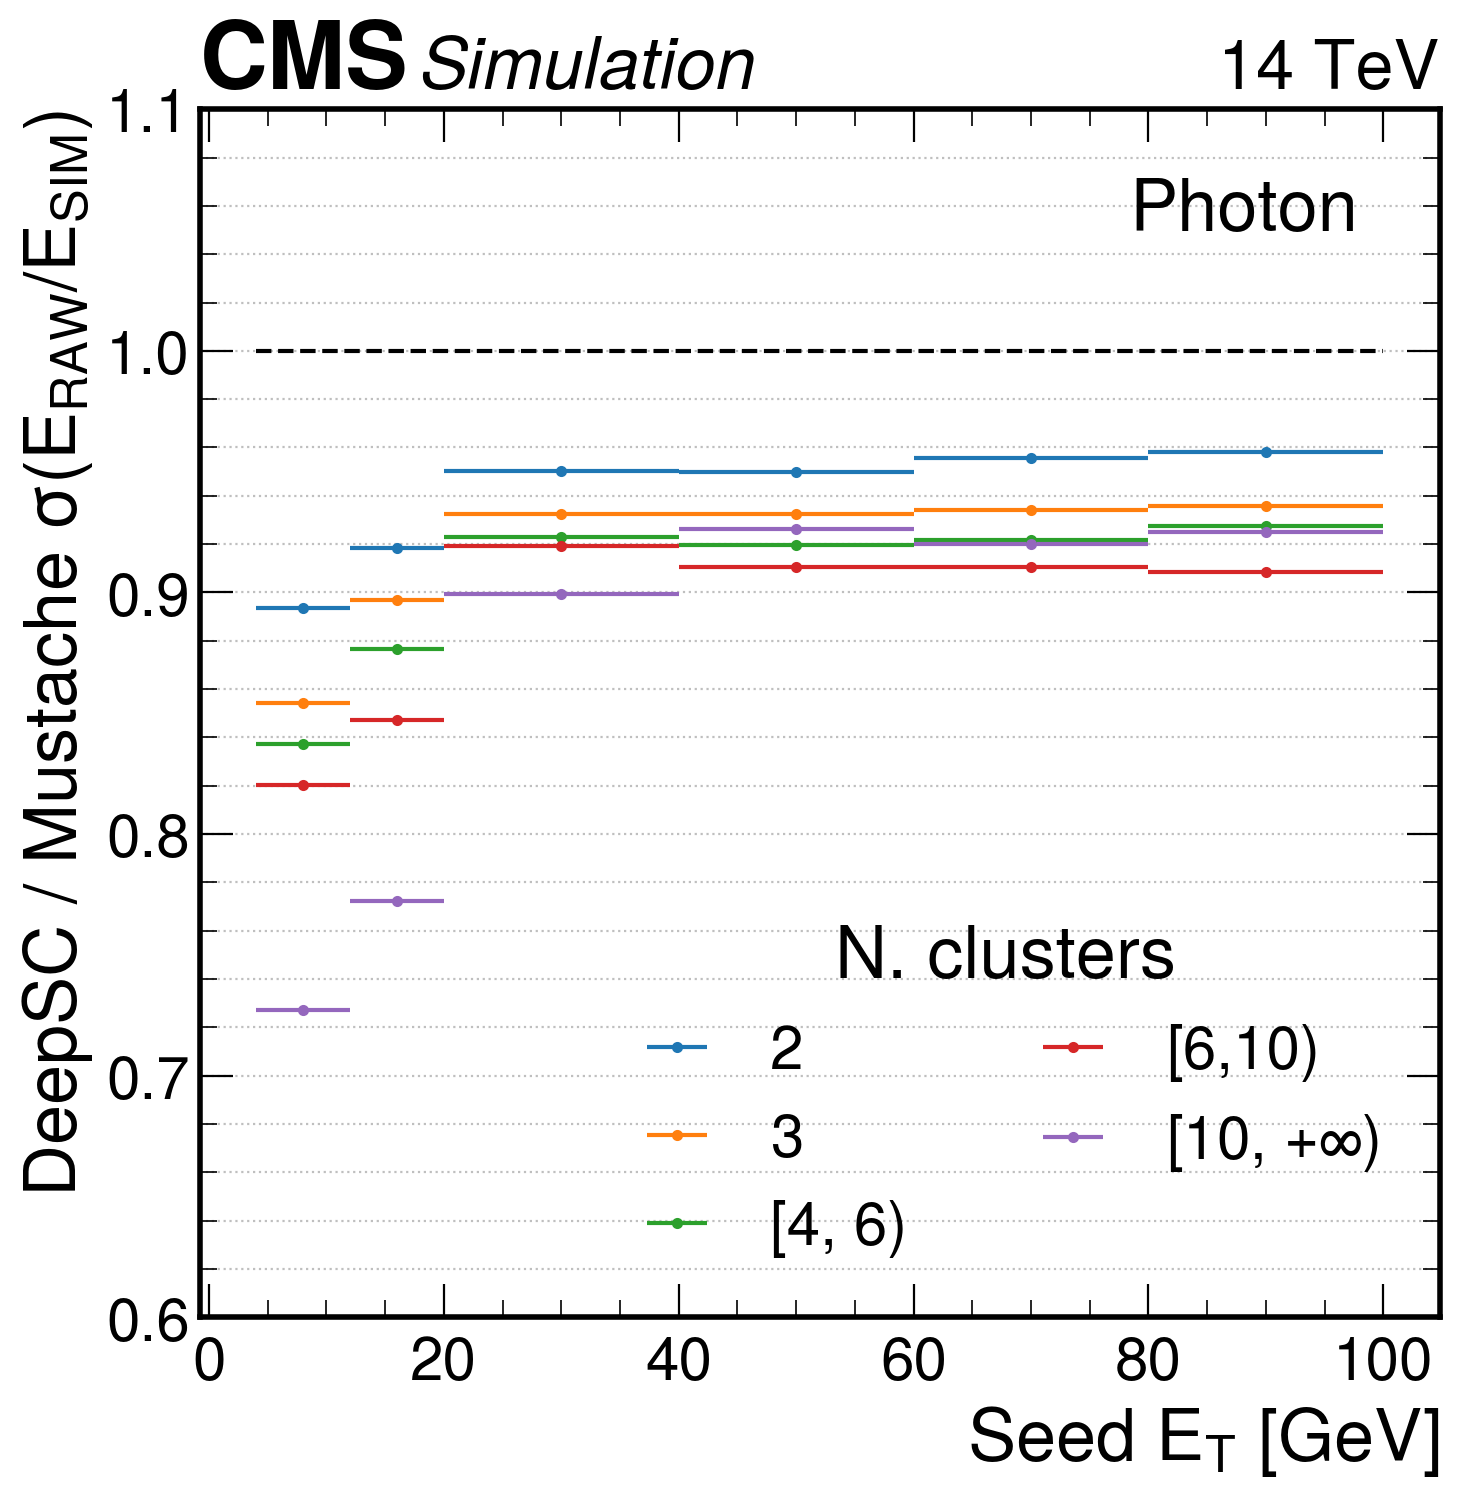

In [136]:
dfs = [df_ele, df_gamma]
flavours = ["Electron", "Photon"]

for df,flavour in zip(dfs, flavours):

    fig, ax = plt.subplots(1,1, figsize=(8,8),dpi=200, )

    ets = [4,12,20,40,60,80,100]
    ncls = [2,3,4,6,10,15]
    
    legends = ["2", "3", "[4, 6)", "[6,10)","[10, $+\infty$)"]
    df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))
    df["ncls_bin"] = pd.cut(df.ncls_tot, ncls, labels=list(range(len(ncls)-1)))


    res = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_deepsc"))
    res_must = df.groupby(["et_bin","ncls_bin"]).apply(bin_analysis("En_ovEtrue_mustache"))
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    errx = []
    x = []
    for i in range(len(ets)-1):
        errx.append((ets[i+1]- ets[i])/2)
        x.append((ets[i+1]+ ets[i])/2)


    # gs = fig.add_gridspec(2, hspace=0.1, height_ratios=[0.8,0.2])
    # axs = gs.subplots(sharex=True)

    for ieta, eta in enumerate(ncls[:-1]):
        ax.errorbar(x, res[res.ncls_bin == ieta].w68/res_must[res_must.ncls_bin == ieta].w68, xerr=errx, label=legends[ieta], fmt=".")


    ax.set_ylim(0.6, 1.1)
    ax.set_ylabel("DeepSC / Mustache $\sigma (E_{RAW}/E_{SIM})$")
    ax.legend(ncol=2, title="N. clusters")

    ax.set_xlabel("Seed $E_T$ [GeV]")
    ax.plot([min(ets),max(ets)],[1,1], linestyle="dashed", color="black")

    ax.grid(axis="y", which="both")
    ax.text(0.75, 0.9, flavour, transform=ax.transAxes)

    hep.cms.label(rlabel="14 TeV", loc=0, ax=ax)



# Resolution by PU

/tmp/ipykernel_1118/1103027523.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["nvtx_bin"] = pd.cut(df.obsPU, nvtx, labels=list(range(len(nvtx)-1)))
/tmp/ipykernel_1118/1103027523.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_1118/1103027523.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

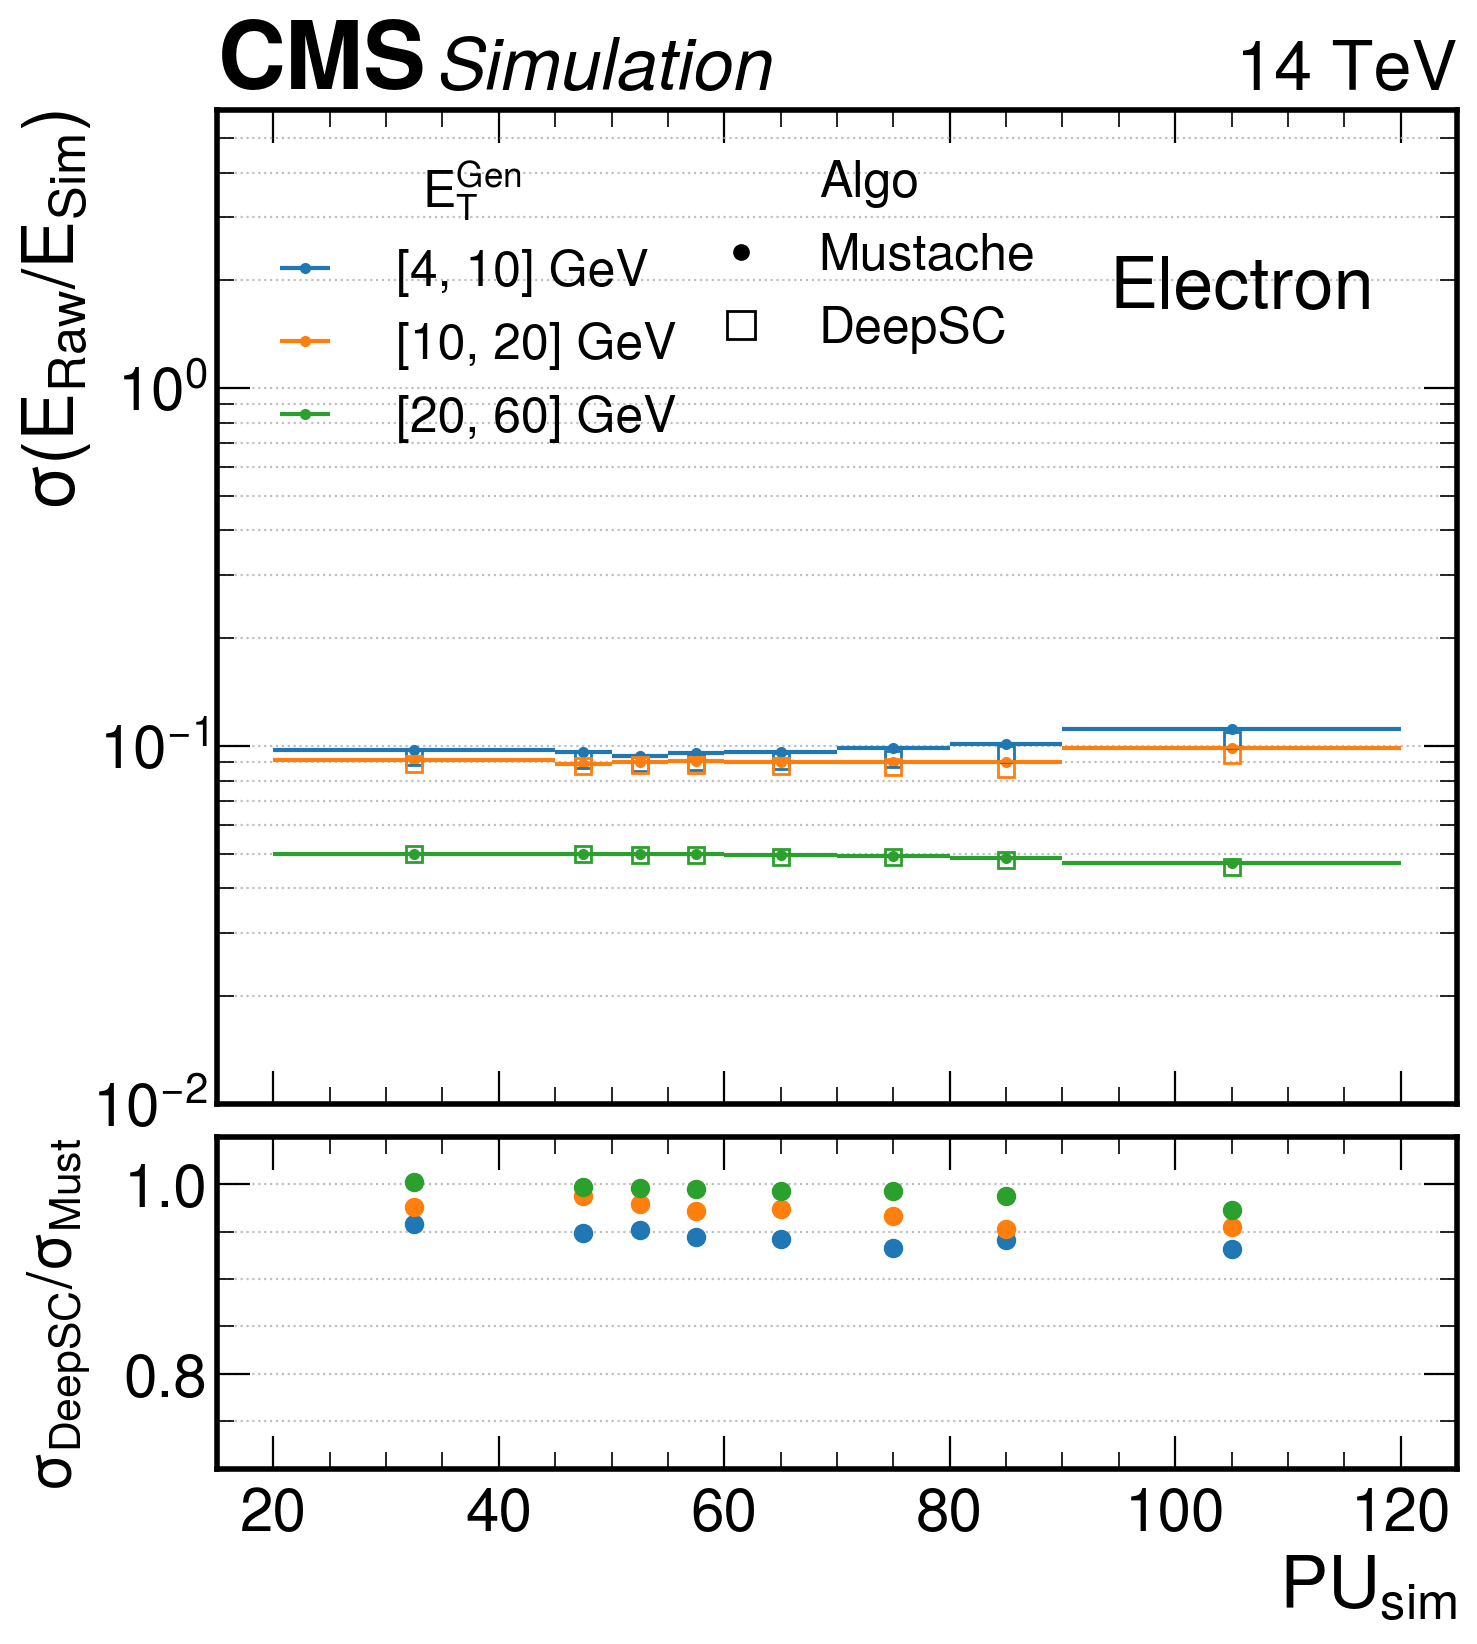

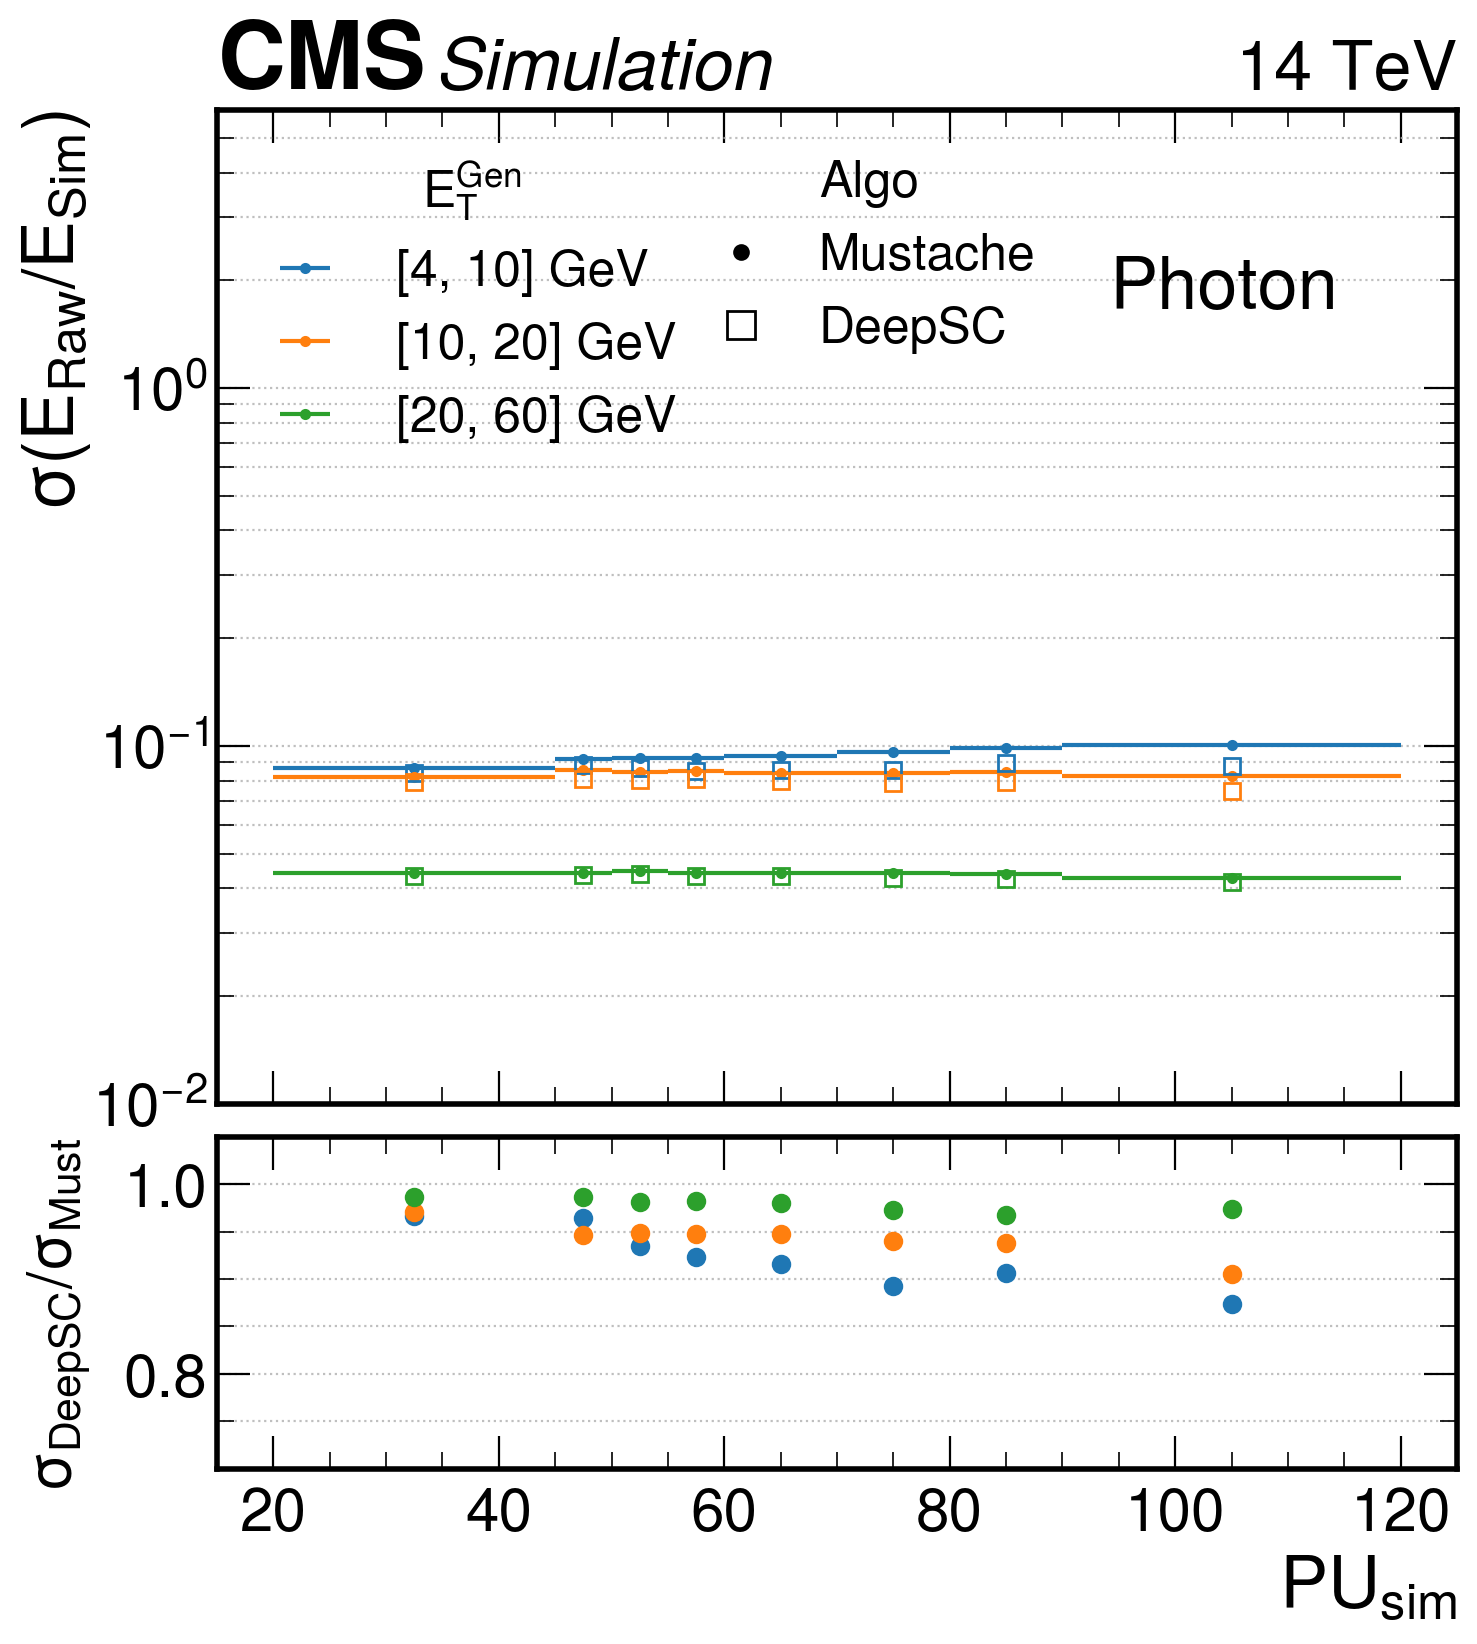

In [135]:
dfs = [df_ele, df_gamma]
flavours = ["Electron","Photon"]

for df,flavour in zip(dfs, flavours):
    nvtx = [20,45,50,55,60,70,80,90,120]
    ets = [4,10, 20,60]
    iplot =[0,1,2,3]
    df["nvtx_bin"] = pd.cut(df.obsPU, nvtx, labels=list(range(len(nvtx)-1)))
    df["et_bin"] = pd.cut(df.calo_et_true_gen, ets, labels=list(range(len(ets)-1)))

    res = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_deepsc"))
    res_must = df.groupby(["nvtx_bin","et_bin"]).apply(bin_analysis("En_ovEtrue_mustache"))
#     avgenraw = df.groupby(["nvtx_bin","et_bin"]).agg({"en_true_sim_good": "mean"})
    res.reset_index(level=0, inplace=True)
    res.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)
    res_must.reset_index(level=0, inplace=True)

    fig = plt.figure(figsize=(8,9), dpi=200)
    gs = fig.add_gridspec(2, hspace=0.05, height_ratios=[0.75,0.25])
    ax, ar = gs.subplots(sharex=True)

    errx = []
    x = []
    for i in range(len(nvtx)-1):
        errx.append((nvtx[i+1]- nvtx[i])/2)
        x.append((nvtx[i+1]+ nvtx[i])/2)
        
    mustl = []
    deepl = []
    
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res_must[res_must.et_bin == iet].w68, xerr=errx, label=" [{}, {}] GeV".format(ets[iet], ets[iet+1]), fmt = ".")
        mustl.append(l)
        
    i =0
    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        l = ax.errorbar(x, res[res.et_bin == iet].w68 , xerr=errx,
                    label="[{}, {}] GeV".format(ets[iet], ets[iet+1]), marker="s", markerfacecolor='none', 
                    c=mustl[i].lines[0].get_color(), linestyle='none', elinewidth=0)
        i+=1
        deepl.append(l)
    
    ax.set_ylim(1e-2, 6)
    ax.set_ylabel("$\sigma (E_{Raw}/E_{Sim})$")
    ax.grid(axis="y", which="both")
    ax.get_yaxis().set_label_coords(-0.1,1)
    ax.set_yscale("log")
    
#     ax.legend(ncol=2, fontsize='x-small', loc="upper left", title="Seed $E_T$", title_fontsize="small")
    l1= ax.legend(handles=mustl, title="$E_T^{Gen}$", title_fontsize=18, loc="upper left", fontsize=18)
    
    ml = mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=10, label='Mustache')
    dl = mlines.Line2D([], [], color='black', marker='s', markerfacecolor='none', linestyle='None', markersize=10, label='DeepSC')
    ax.legend(handles=[ml,dl], title="Algo", title_fontsize=18, loc="upper right",bbox_to_anchor=(0.7, 1), fontsize=18)
    ax.add_artist(l1)

    ax.text(0.72, 0.8, flavour, transform=ax.transAxes)
    hep.cms.label( loc=0, ax=ax, rlabel="14 TeV")

    for iet, et in enumerate(ets[:-1]):
        if iet not in iplot: continue
        #v =res_must[res_must.et_bin == iet].w68**2 - res[res.et_bin == iet].w68**2
        #var = np.sqrt(np.abs(v))*np.sign(v) / res_must[res_must.et_bin == iet].w68
        var = res[res.et_bin == iet].w68 / res_must[res_must.et_bin==iet].w68
        ar.errorbar(x, var, xerr=errx, label="$E_T^{Gen}$" + " [{}, {}] GeV".format(ets[iet], ets[iet+1]),fmt="o", linestyle='none', elinewidth=0 )
        
    ar.set_ylim(0.7, 1.05)
    ar.set_ylabel("$\sigma_{DeepSC}/\sigma_{Must}$", fontsize=22)
    
    ar.get_yaxis().set_label_coords(-0.1,1)
    
#     ar.legend(ncol=3,prop={'size': 13}, loc="lower left" )
    
    ar.set_xlabel("$PU_{sim}$")
    ar.grid(axis="y", which="both")

    fig.savefig(output_folder + "/resolution_byPU_{}_ratio.png".format(flavour))
    fig.savefig(output_folder + "/resolution_byPU_{}_ratio.pdf".format(flavour))
    fig.savefig(output_folder + "/resolution_byPU_{}_ratio.svg".format(flavour))
